In [1]:
import os
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import defaultdict

export_dir = "ablation_outputs"
os.makedirs(export_dir, exist_ok=True)


base_dir = "results/Ensemble_ablation"
VALID_TOPFRACS = {"0.2", "0.3", "0.5", "0.7"}
VALID_THRESHOLDS = {"1", "3", "5"}
INVALID_GT_VIDEOS = {"seq1", "seq2", "seq3", "seq4"}

# To accumulate RPE/Reproj error data
all_metrics = []

# To accumulate ATE per matcher
ate_dict = {}

skip_stats=[]



### Helper Functions

In [2]:
def load_ate_scalar(path):
    """ The ATE.npy file contains a single value per frame, which is the ATE for that frame.
    This function loads the ATE.npy file and returns the average ATE across all frames.
    """
    try:
        val = np.load(path)
        val = np.array(val).astype(float).flatten()
        return val.mean()  # Average ATE across frames
    except Exception as e:
        print(f"Failed to load {path}: {e}")
        return None



def show_scrollable_df(df, max_height="400px", max_width="100%"):
    display(HTML(f"""
        <div style="max-height:{max_height}; max-width:{max_width}; overflow:auto; border:1px solid #ccc; padding:10px">
            {df.to_html(index=False)}
        </div>
    """))


def compute_motion(gt_poses):
    motions = []
    for i in range(1, len(gt_poses)):
        T1 = gt_poses[i-1]
        T2 = gt_poses[i]
        T_rel = np.linalg.inv(T1) @ T2
        trans = np.linalg.norm(T_rel[:3, 3])
        rot_deg = R.from_matrix(T_rel[:3, :3]).magnitude() * (180 / np.pi)
        motions.append({
            "frame": i,
            "combined_motion": trans + rot_deg
        })
    return pd.DataFrame(motions)





### Load Data

In [3]:

# Load data from all videos and matchers
for video in os.listdir(base_dir):
    if video in INVALID_GT_VIDEOS:
        continue  # Skip invalid GT videos
    print(f"Processing video: {video}")
    video_path = os.path.join(base_dir, video)
    if not os.path.isdir(video_path):
        continue

    for matcher in os.listdir(video_path):
        matcher_path = os.path.join(video_path, matcher)
        metrics_file = os.path.join(matcher_path, "metrics_ensemble.csv")
        ate_file = os.path.join(matcher_path, "ate_ensemble.npy")
        skip_log_file = os.path.join(matcher_path, "skip_log_ensemble.csv")

        # Parse topfrac/thresh from matcher name
        match = re.search(r"topfrac(\d\.\d)_thresh(\d+)", matcher)
        if not match:
            continue  # skip if pattern not found
        topfrac, thresh = match.groups()
        if topfrac not in VALID_TOPFRACS or thresh not in VALID_THRESHOLDS:
            continue  # skip non-included runs

        # Load metrics
        if os.path.isfile(metrics_file):
            df = pd.read_csv(metrics_file)
            df["matcher"] = matcher
            df["video"] = video
            all_metrics.append(df)

        # Load ATE
        if os.path.isfile(ate_file):
            ate_value = load_ate_scalar(ate_file)
            if ate_value is not None and ate_value > 0:
                ate_dict.setdefault(matcher, []).append(ate_value)
            else:
                print(f"[SKIP] Invalid or 0 ATE for {matcher} ({video})")

        # Load skip log
        if os.path.isfile(skip_log_file):
            try:
                skip_df = pd.read_csv(skip_log_file)
                total = len(skip_df)
                failed = skip_df["success"].value_counts().get(False, 0)
                avg_skip_used = skip_df["skip_used"].mean()

                skip_stats.append({
                    "matcher": matcher,
                    "video": video,
                    "failures": failed,
                    "total": total,
                    "failure_rate": failed / total if total > 0 else np.nan,
                    "avg_skip_used": avg_skip_used
                })

            except Exception as e:
                print(f"[WARN] Failed to load skip log from {skip_log_file}: {e}")

# --- Combine & Aggregate ---
metrics_df = pd.concat(all_metrics, ignore_index=True)

# Group by matcher and compute mean and std metrics
agg_funcs = {
    "rotation_error_deg": ["mean", "std"],
    "translation_error_deg": ["mean", "std"],
    "mean_reprojection_error_px": ["mean", "std"]
}
summary_df = metrics_df.groupby("matcher").agg(agg_funcs)
summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]
summary_df = summary_df.reset_index()

# Add ATE means and stds
ate_avg = {matcher: np.mean(values) for matcher, values in ate_dict.items()}
ate_std = {matcher: np.std(values) for matcher, values in ate_dict.items()}
summary_df["ATE_mean"] = summary_df["matcher"].map(ate_avg)
summary_df["ATE_std"] = summary_df["matcher"].map(ate_std)

# Add skip log stats
skip_df = pd.DataFrame(skip_stats)
skip_summary = skip_df.groupby("matcher").agg({
    "failure_rate": "mean",
    "avg_skip_used": "mean"
}).reset_index()

summary_df = summary_df.merge(skip_summary, on="matcher", how="left")

# OPTIONAL: sort or inspect
summary_df = summary_df.sort_values("ATE_mean")


Processing video: cecum_t2_c
Processing video: sigmoid_t3_a
Processing video: cecum_t2_a
Processing video: cecum_t1_a
Processing video: desc_t4_a
Processing video: trans_t3_a
Processing video: cecum_t2_b
Processing video: cecum_t4_b
Processing video: cecum_t1_b
Processing video: trans_t3_b
Processing video: sigmoid_t3_b
Processing video: trans_t2_a
Processing video: sigmoid_t1_a
Processing video: trans_t1_a
Processing video: trans_t2_b
Processing video: cecum_t3_a
Processing video: sigmoid_t2_a
Processing video: trans_t4_b
Processing video: cecum_t4_a
Processing video: trans_t4_a
Processing video: trans_t1_b
Processing video: trans_t2_c


In [4]:
# Save and display summary
summary_df.to_csv("ensemble_full_summary.csv", index=False)
show_scrollable_df(summary_df)


matcher,rotation_error_deg_mean,rotation_error_deg_std,translation_error_deg_mean,translation_error_deg_std,mean_reprojection_error_px_mean,mean_reprojection_error_px_std,ATE_mean,ATE_std,failure_rate,avg_skip_used
ensemble_topfrac0.2_thresh3,1.192319,6.236002,49.368166,24.454284,34.553770,113.184813,7.980118,6.748378,0.008185,1.040911
ensemble_topfrac0.2_thresh5,0.850168,4.284046,49.386575,24.533164,28.163517,80.760164,8.307860,6.978678,0.012522,1.043102
ensemble_topfrac0.7_thresh5,0.656853,2.840533,49.337662,24.632217,25.380332,36.678321,9.403361,12.231287,0.004947,1.022639
ensemble_topfrac0.3_thresh3,1.130633,6.482741,48.975013,25.012160,70.056072,689.196293,10.144094,14.948395,0.002674,1.021268
ensemble_topfrac0.3_thresh1,1.144570,6.533812,49.242132,25.225124,70.719443,694.711761,10.285879,14.237369,0.012522,1.033435
ensemble_topfrac0.7_thresh1,0.684309,3.053038,49.363127,24.596562,25.242419,40.292637,10.367438,14.900219,0.006209,1.021340
ensemble_topfrac0.3_thresh5,0.849771,4.587057,48.971266,24.806417,63.726268,684.421320,10.376450,14.297029,0.004947,1.025164
ensemble_topfrac0.5_thresh3,0.556708,1.874270,49.169249,24.582729,23.437042,22.073540,10.409297,13.798802,0.004947,1.024705
ensemble_topfrac0.5_thresh1,0.559774,1.877430,49.375059,24.931001,23.232318,22.085958,10.586043,14.976055,0.004947,1.026771
ensemble_topfrac0.7_thresh3,0.694986,3.124646,49.289585,24.571993,25.537161,41.554183,10.612081,15.055448,0.004947,1.026599


### Average ATE by matcher ensemble - bar plot

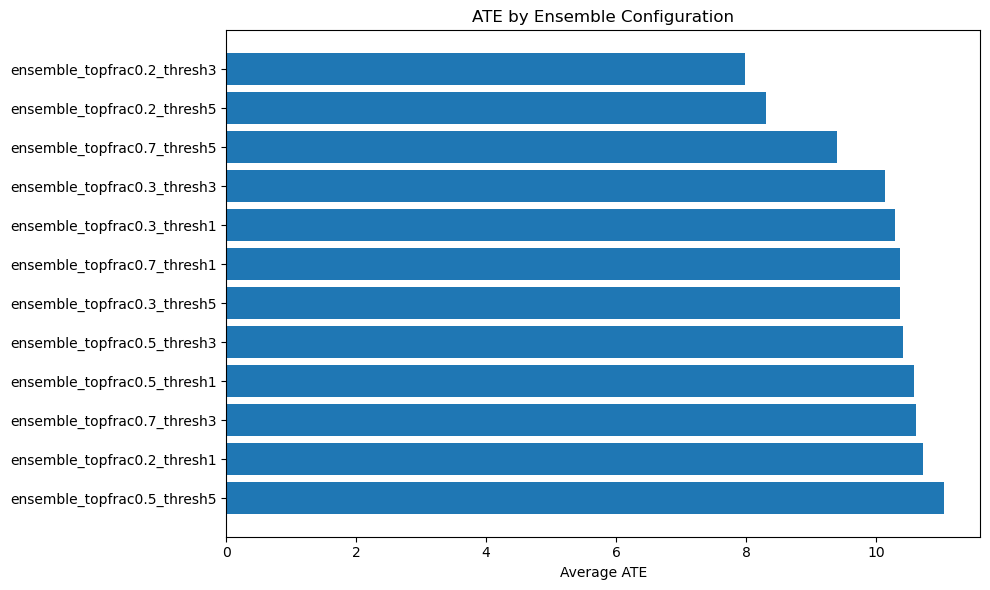

In [5]:


# Sort by ATE ascending, then reverse so smallest is on top
sorted_df = summary_df.sort_values("ATE_mean", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(sorted_df["matcher"], sorted_df["ATE_mean"])
plt.xlabel("Average ATE")
plt.title("ATE by Ensemble Configuration")
plt.gca().invert_yaxis()  # <-- This inverts the y-axis so smallest ATE is at the top
plt.tight_layout()
plt.savefig(os.path.join(export_dir, 'ate_bar_plot.png'), dpi=300)
# plt.close()


### ATE per matcher ensemble - averaged across videos - with standard deviation

(0.0, 27.582735807628744)

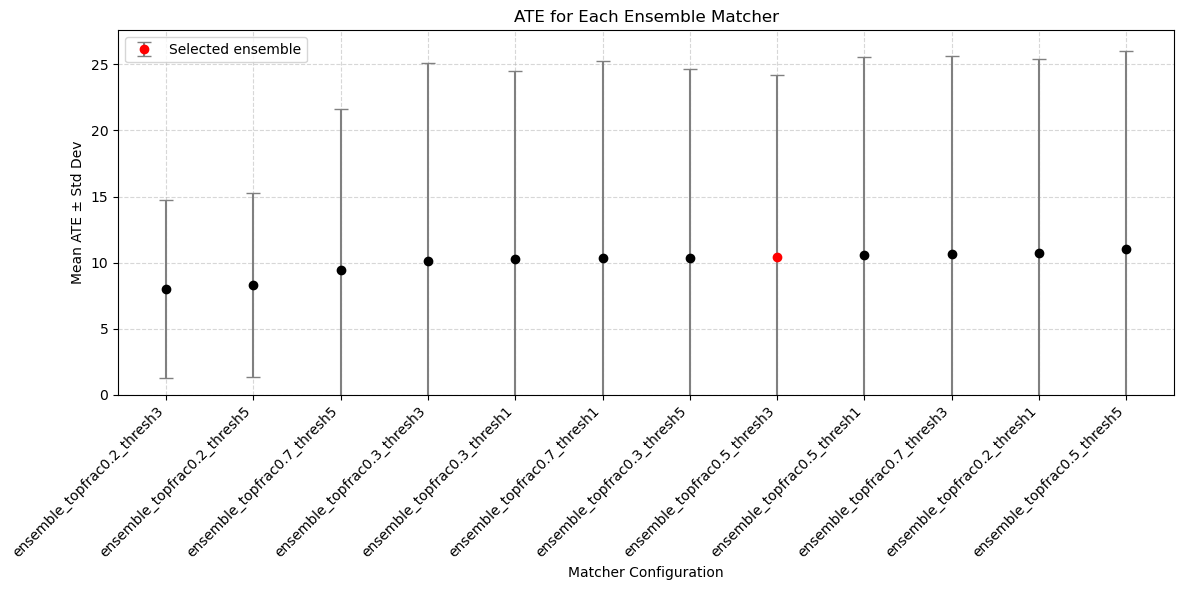

In [6]:
# Define the matcher to highlight
highlight_matcher = "ensemble_topfrac0.5_thresh3"
ate_stats_df = pd.DataFrame([
    {"matcher": matcher, "mean_ate": np.mean(values), "std_ate": np.std(values)}
    for matcher, values in ate_dict.items()
])

plot_df = summary_df.merge(ate_stats_df, on="matcher", how="left")

plt.figure(figsize=(12, 6))
# Plot all matchers with individual styling
for i, row in plot_df.iterrows():
    color = 'red' if row["matcher"] == highlight_matcher else 'black'
    plt.errorbar(
        x=row["matcher"],
        y=row["mean_ate"],
        yerr=row["std_ate"],
        fmt='o',
        ecolor='gray',
        capsize=5,
        color=color,
        label="Selected ensemble" if row["matcher"] == highlight_matcher else None
    )

plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean ATE ± Std Dev")
plt.xlabel("Matcher Configuration")
plt.title("ATE for Each Ensemble Matcher")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(export_dir, 'ate_std_highlighted.png'), dpi=300)
plt.ylim(bottom=0)

# plt.close()


### Average RPE trans vs Rot by matcher ensemble - scatter plot

Correlation between rotation and translation errors:
Pearson correlation coefficient: 0.2404
P-value: 0.4516
The correlation is not statistically significant (p >= 0.05)


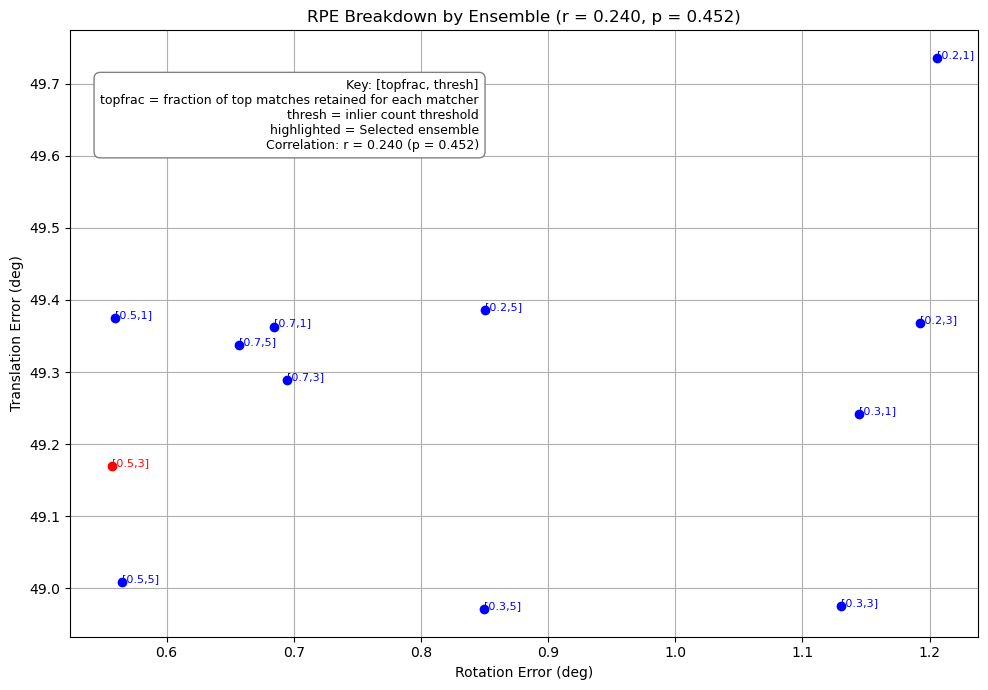

In [7]:
import matplotlib.pyplot as plt
import re
import numpy as np
from scipy.stats import pearsonr

# Define the matcher labels you want to highlight
highlight_set = {
    ("0.5", "3"),
}

plt.figure(figsize=(10, 7))

# Lists to store data for correlation calculation
x_values = []
y_values = []

for _, row in summary_df.iterrows():
    matcher = row["matcher"]
    x = row["rotation_error_deg_mean"]
    y = row["translation_error_deg_mean"]
    
    # Store values for correlation
    x_values.append(x)
    y_values.append(y)
    
    # Extract topfrac and thresh
    match = re.search(r"topfrac(\d\.\d)_thresh(\d+)", matcher)
    if match:
        topfrac, thresh = match.groups()
        label = f"[{topfrac},{thresh}]"
        is_highlight = (topfrac, thresh) in highlight_set
    else:
        label = matcher
        is_highlight = False
    
    # Choose color based on highlight
    color = "red" if is_highlight else "blue"
    plt.scatter(x, y, color=color)
    plt.annotate(label, (x, y), fontsize=8, color=color)

# Calculate correlation
correlation_coeff, p_value = pearsonr(x_values, y_values)

# Axis labels and title
plt.xlabel("Rotation Error (deg)")
plt.ylabel("Translation Error (deg)")
plt.title(f"RPE Breakdown by Ensemble (r = {correlation_coeff:.3f}, p = {p_value:.3f})")
plt.grid(True)
plt.tight_layout()

# Key box inside the plot (updated to include correlation info)
plt.text(
    0.45, 0.80,
    f"Key: [topfrac, thresh]\n"
    f"topfrac = fraction of top matches retained for each matcher\n"
    f"thresh = inlier count threshold\n"
    f"highlighted = Selected ensemble\n"
    f"Correlation: r = {correlation_coeff:.3f} (p = {p_value:.3f})",
    transform=plt.gca().transAxes,
    fontsize=9,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray")
)

# Print correlation results
print(f"Correlation between rotation and translation errors:")
print(f"Pearson correlation coefficient: {correlation_coeff:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("The correlation is statistically significant (p < 0.05)")
else:
    print("The correlation is not statistically significant (p >= 0.05)")

plt.savefig(os.path.join(export_dir, 'RPE_trans_rot_by_ensemble.png'), dpi=300)
# plt.close()

### Mean Reprojection Error by topfrac and thresh - heatmap

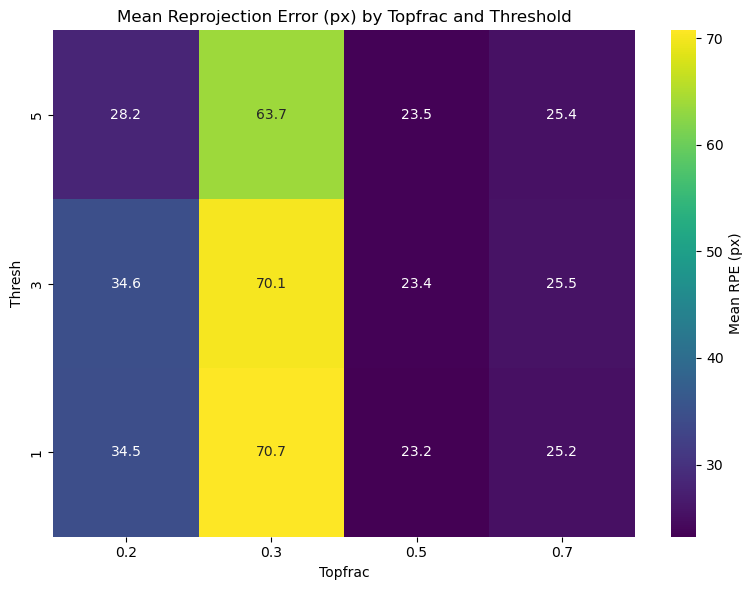

In [8]:
import seaborn as sns

# --- Create Mean RPE Heatmap ---

# Extract topfrac and thresh from matcher
summary_df["topfrac"] = summary_df["matcher"].str.extract(r"topfrac(\d\.\d)").astype(float)
summary_df["thresh"] = summary_df["matcher"].str.extract(r"thresh(\d+)").astype(int)

# Create pivot table: rows = thresh, columns = topfrac (swapped)
rpe_pivot = summary_df.pivot_table(
    index="thresh",
    columns="topfrac", 
    values="mean_reprojection_error_px_mean"
)

# Reverse the order of thresh (rows)
rpe_pivot = rpe_pivot.sort_index(ascending=False)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(rpe_pivot, annot=True, fmt=".1f", cmap="viridis", cbar_kws={'label': 'Mean RPE (px)'})
plt.title("Mean Reprojection Error (px) by Topfrac and Threshold")
plt.ylabel("Thresh")
plt.xlabel("Topfrac")
plt.tight_layout()
plt.savefig(os.path.join(export_dir, "rpe_heatmap.png"), dpi=300)
# plt.close()

### ATE Heatmap thresh vs topfrac

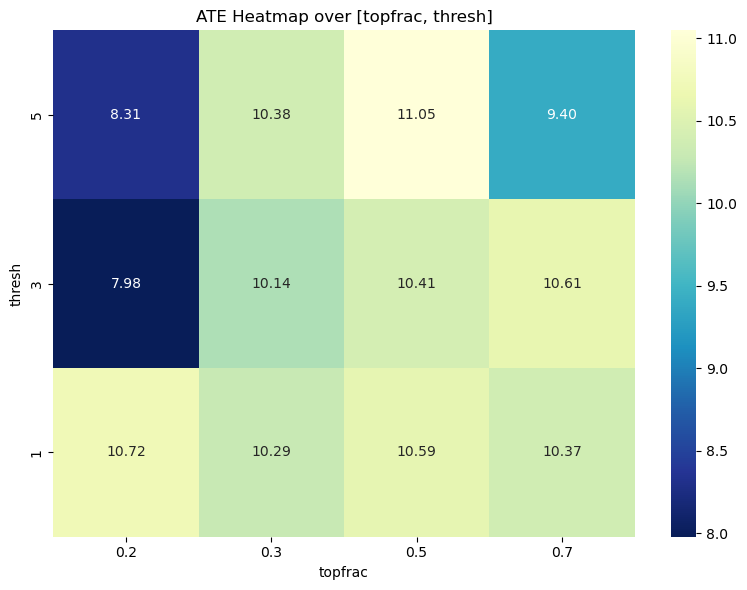

In [9]:
summary_df["topfrac"] = summary_df["matcher"].str.extract(r"topfrac(\d\.\d)")[0].astype(float)
summary_df["thresh"] = summary_df["matcher"].str.extract(r"thresh(\d+)")[0].astype(int)

heatmap_data = summary_df.pivot(index="thresh", columns="topfrac", values="ATE_mean")
heatmap_data = heatmap_data.sort_index(ascending=False)

plt.figure(figsize=(8, 6))
# Invert the colormap so lower ATE = darker
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu_r")

plt.title("ATE Heatmap over [topfrac, thresh]")
plt.xlabel("topfrac")
plt.ylabel("thresh")
plt.tight_layout()
plt.savefig(os.path.join(export_dir, 'RPE_heatmap_ensemble.png'), dpi=300)
plt.show()


### Failure rate by topfrac and thresh - heatmap

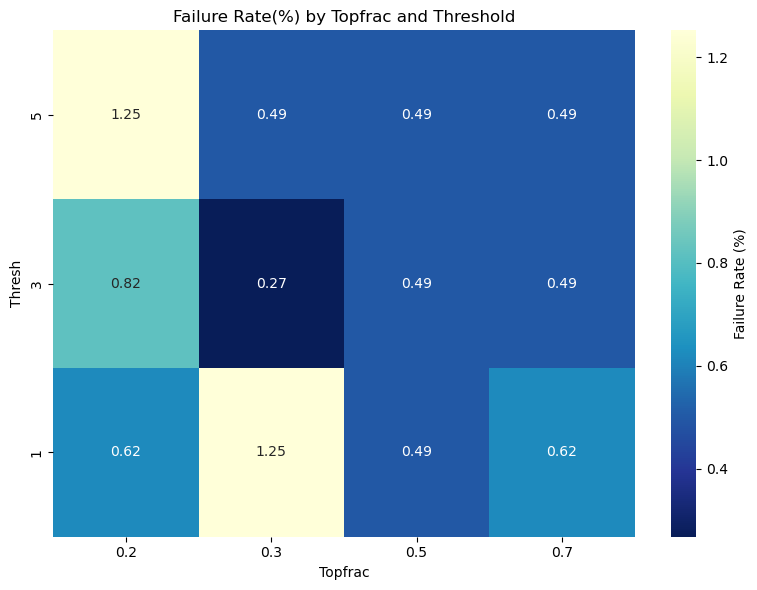

In [10]:
# Extract topfrac and thresh from matcher
summary_df["topfrac"] = summary_df["matcher"].str.extract(r"topfrac(\d\.\d)").astype(float)
summary_df["thresh"] = summary_df["matcher"].str.extract(r"thresh(\d+)").astype(int)

# Create pivot table: rows = thresh, columns = topfrac (swapped)
rpe_pivot = summary_df.pivot_table(
    index="thresh",
    columns="topfrac", 
    values="failure_rate"
)

# Reverse the order of thresh (rows)
rpe_pivot = rpe_pivot.sort_index(ascending=False)

# Plot the heatmap
plt.figure(figsize=(8, 6))
# Convert to percentages and show 1 decimal place
sns.heatmap(rpe_pivot * 100, annot=True, fmt=".2f", cmap="YlGnBu_r", cbar_kws={'label': 'Failure Rate (%)'})
plt.title("Failure Rate(%) by Topfrac and Threshold")
plt.ylabel("Thresh")
plt.xlabel("Topfrac")
plt.tight_layout()
plt.savefig(os.path.join(export_dir, "failure_rate_heatmap.png"), dpi=300)
# plt.close()

### Motion vs Reprojection Error (one plot per video)

/tmp/ipykernel_1074063/3453197948.py:78: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


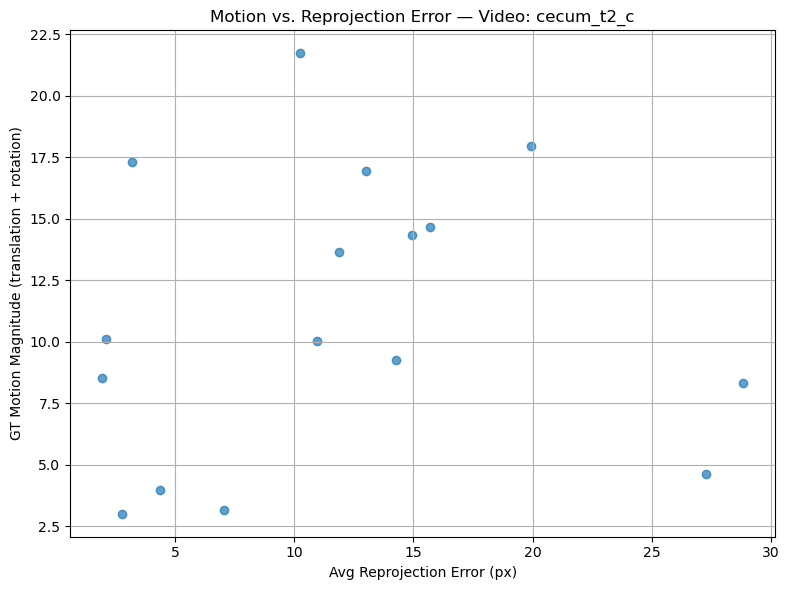

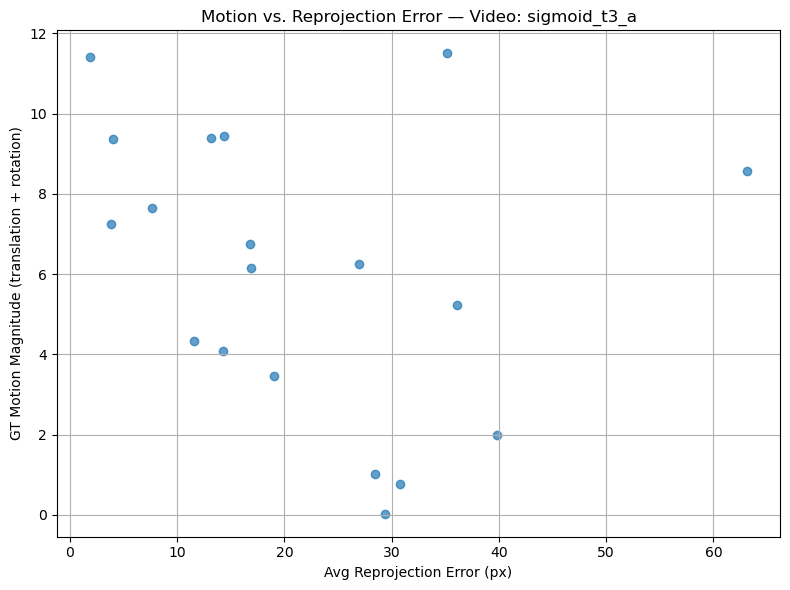

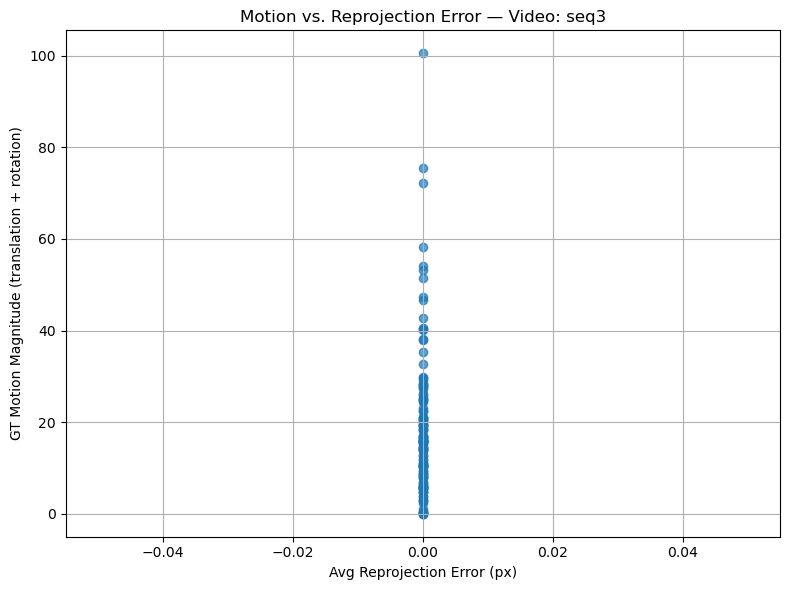

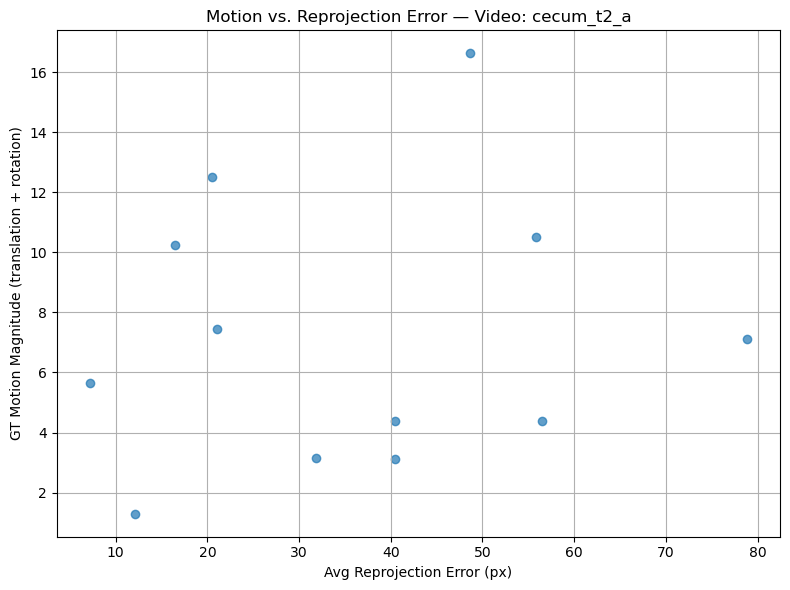

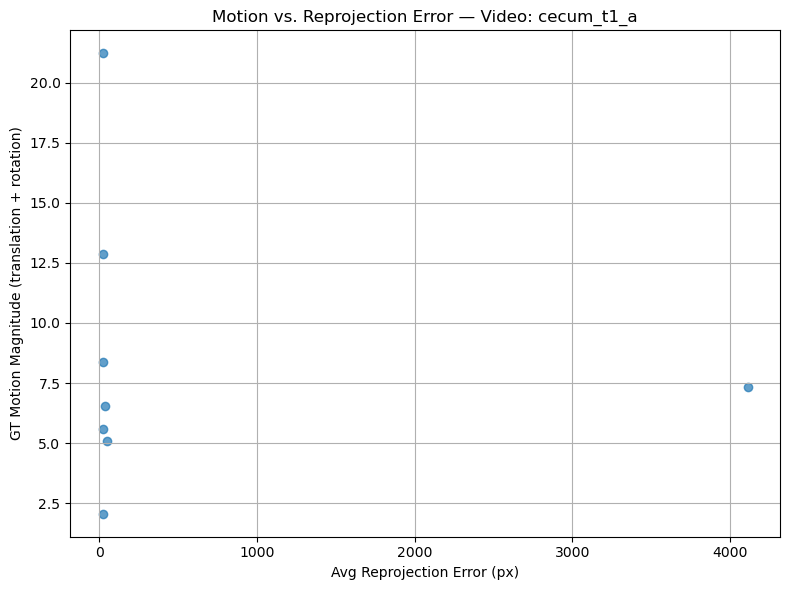

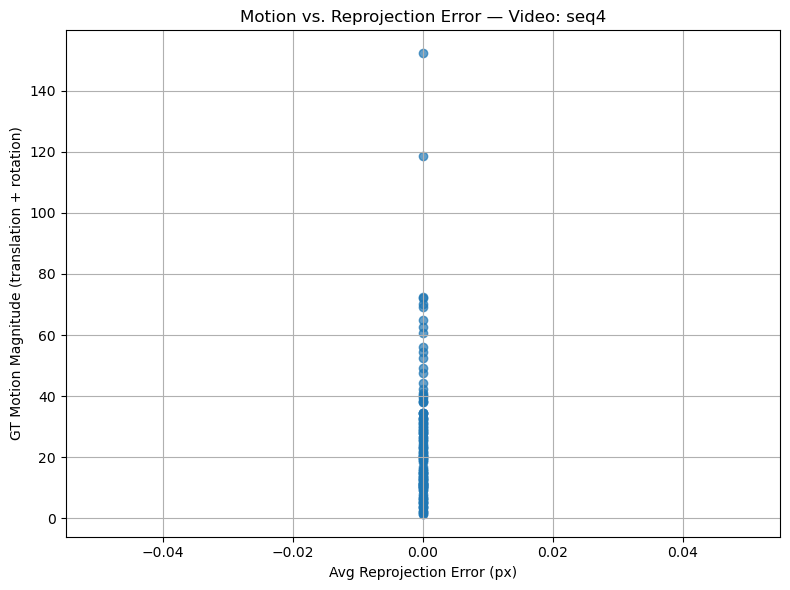

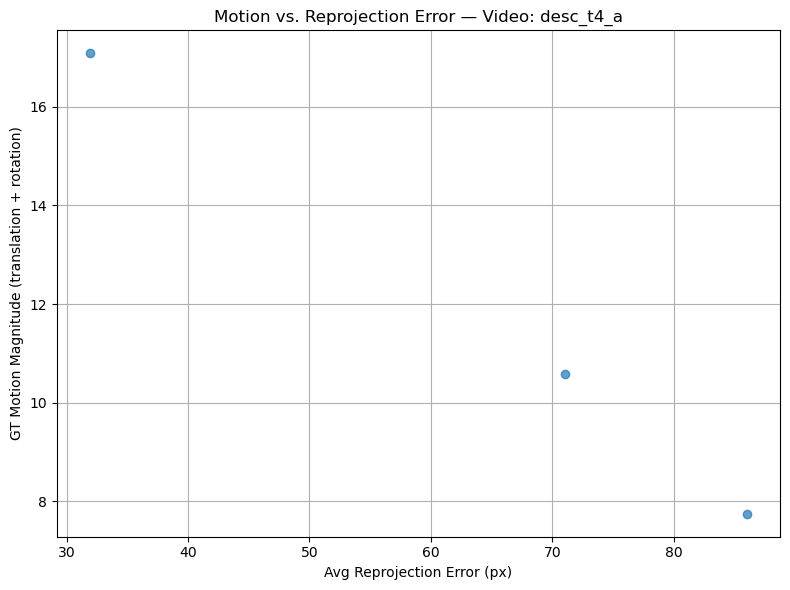

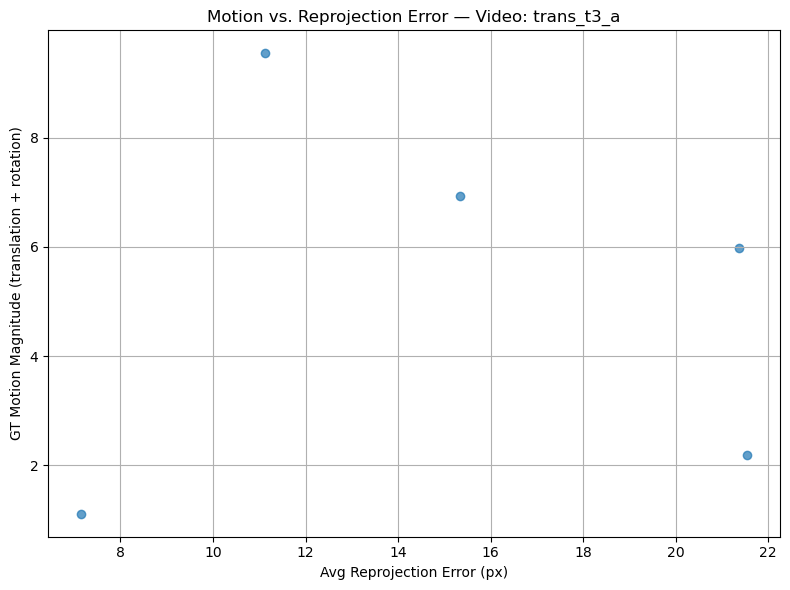

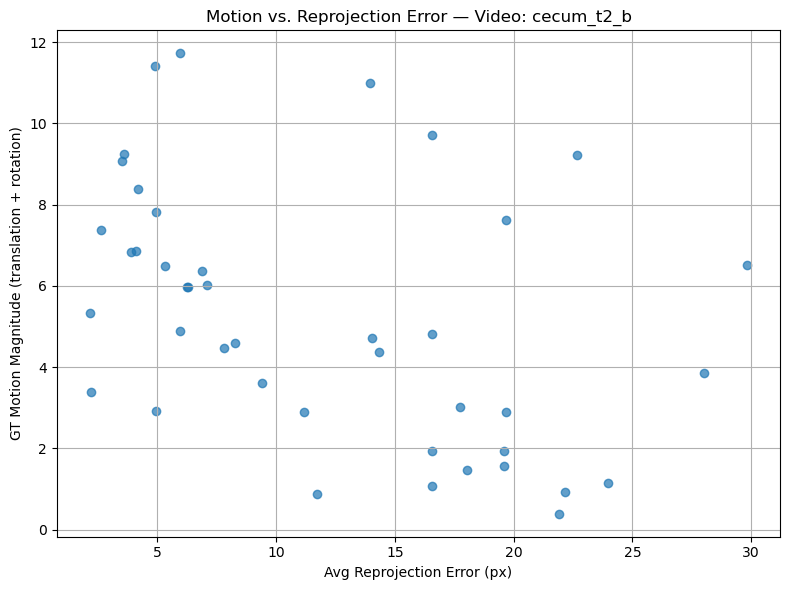

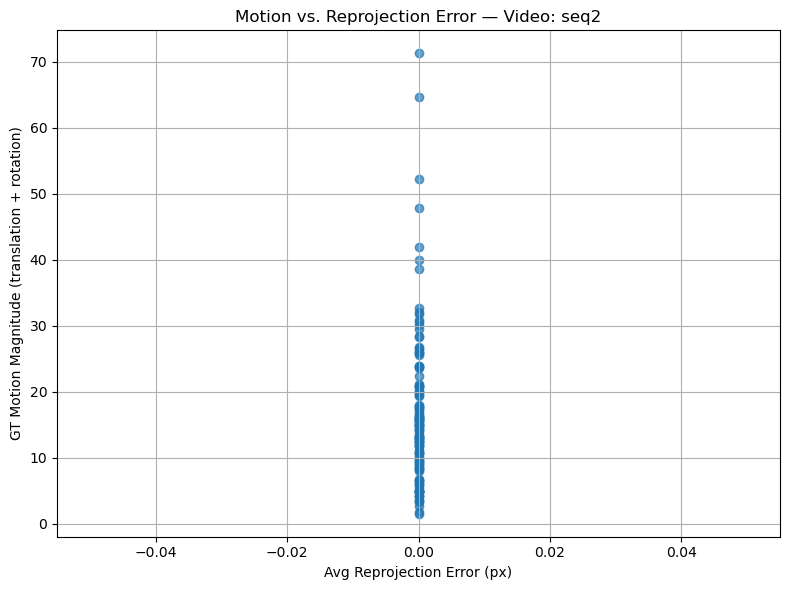

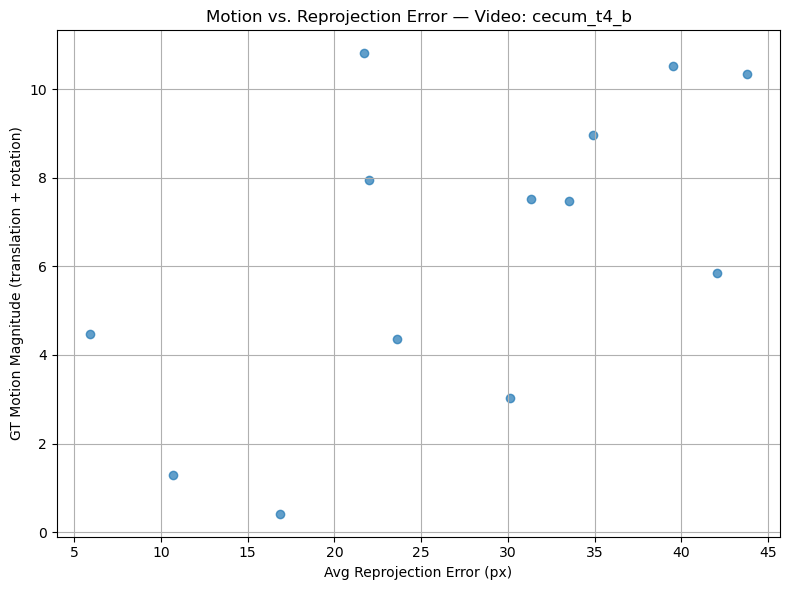

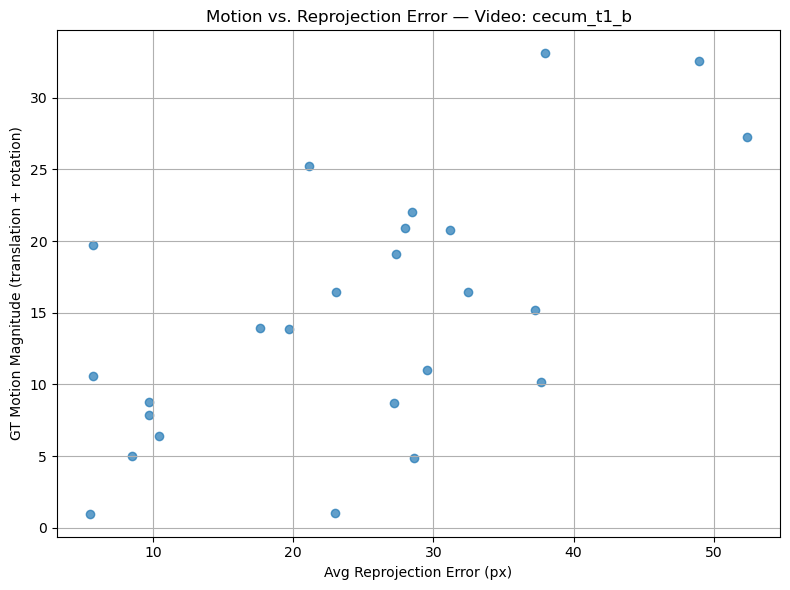

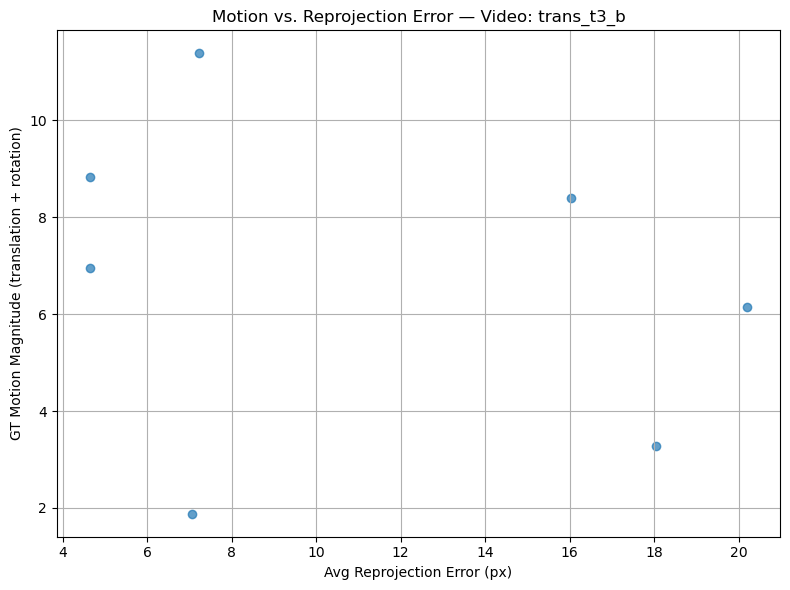

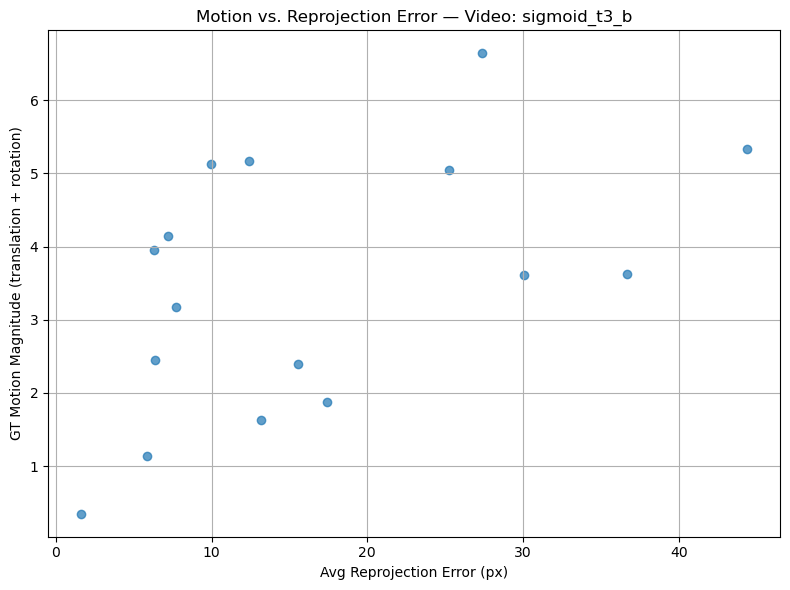

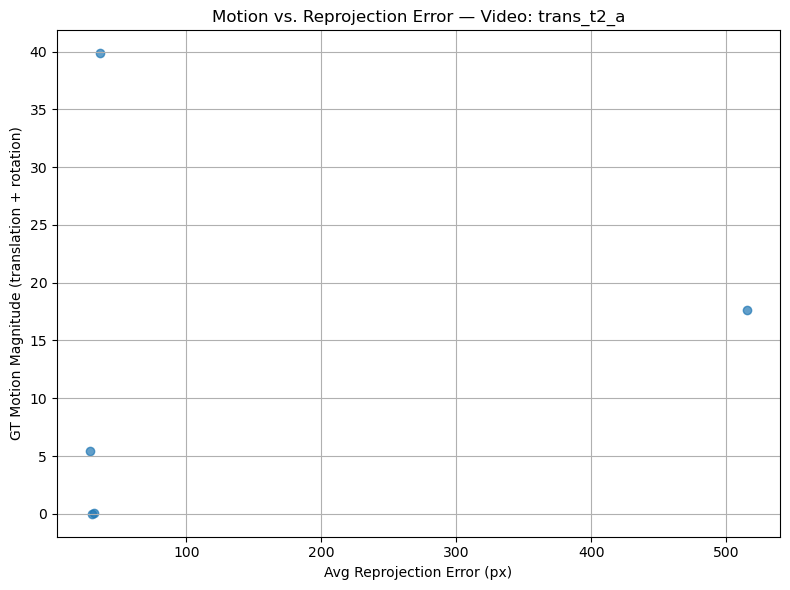

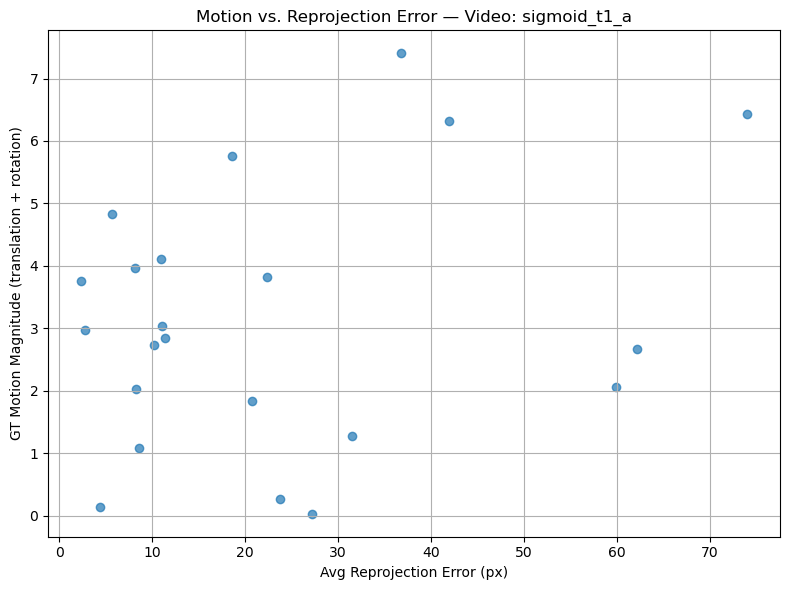

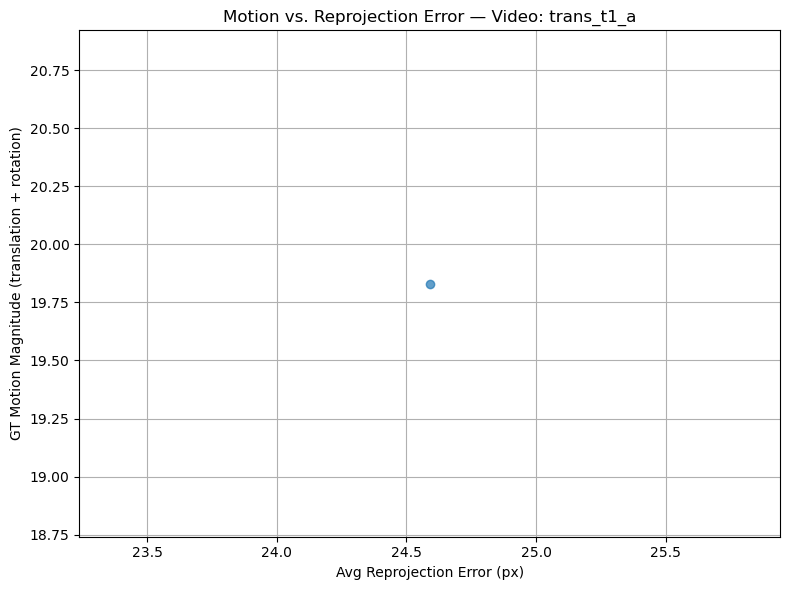

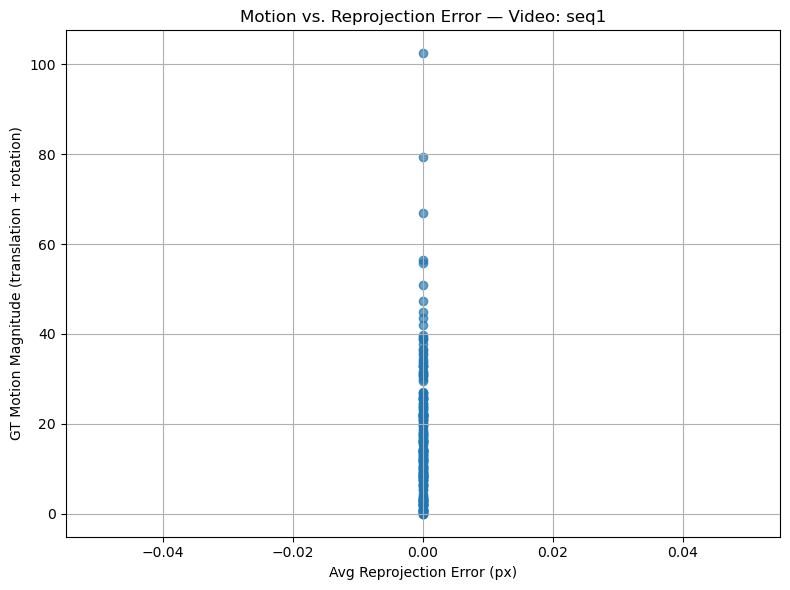

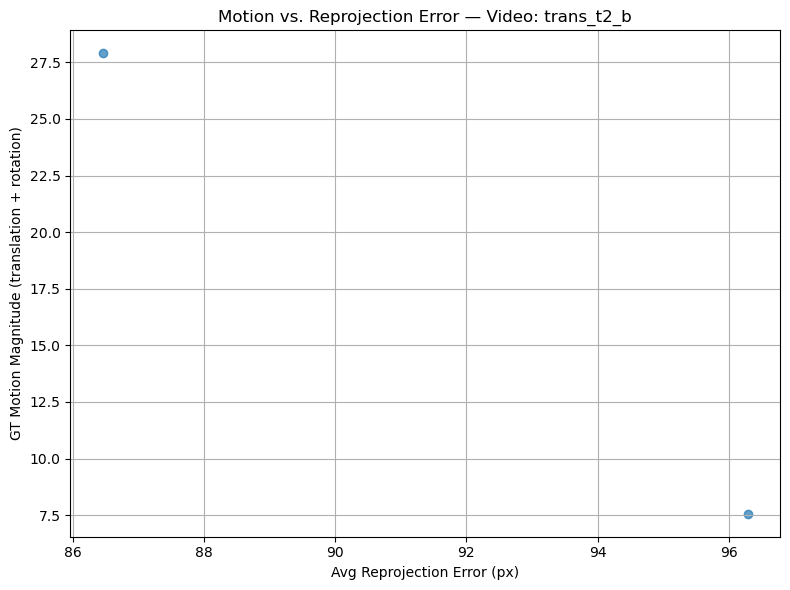

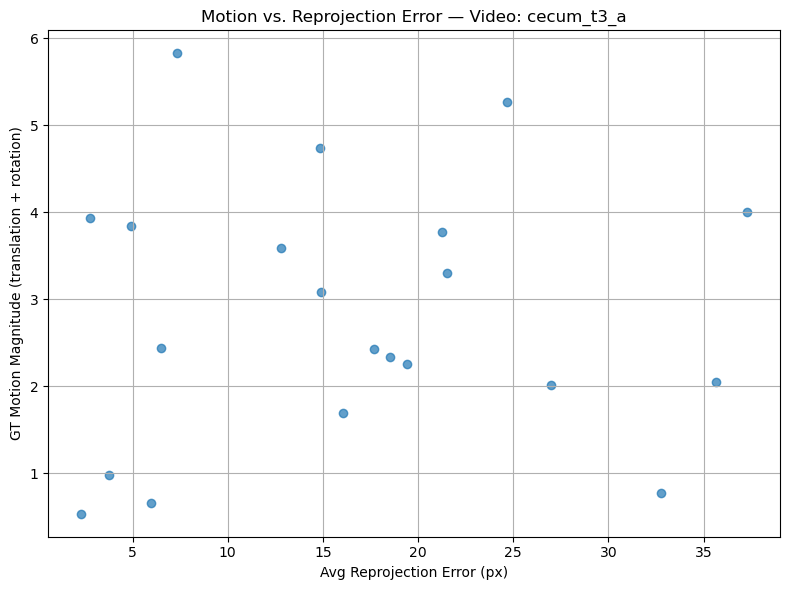

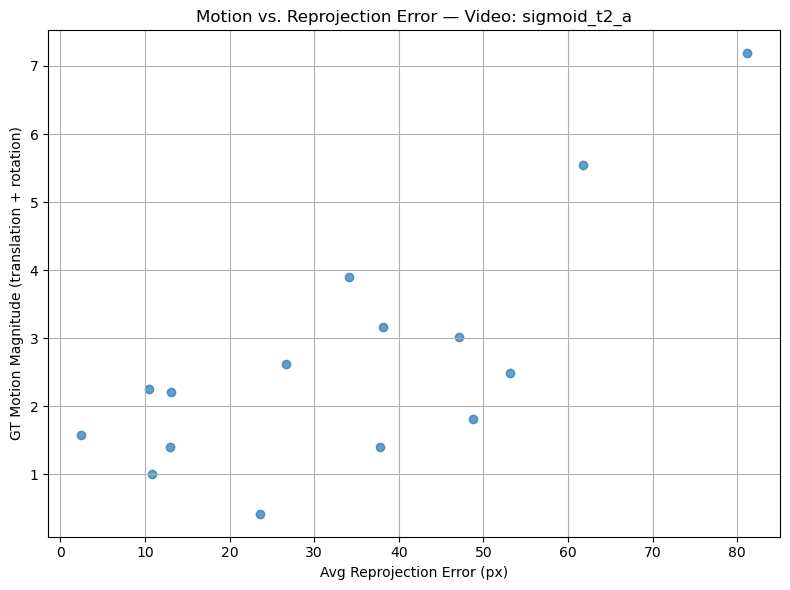

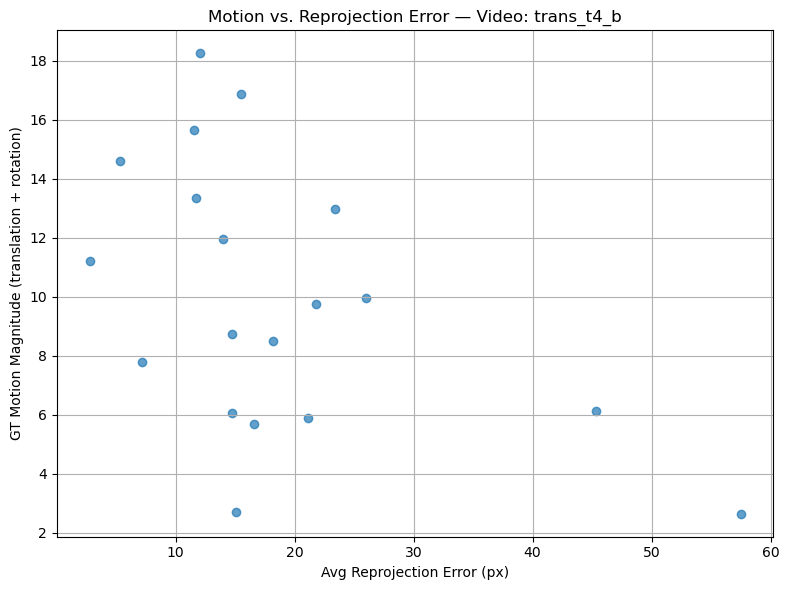

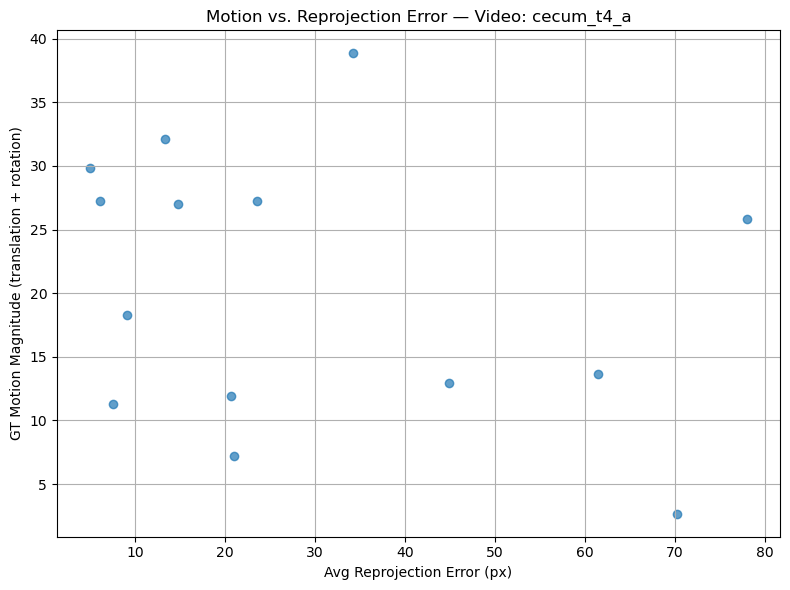

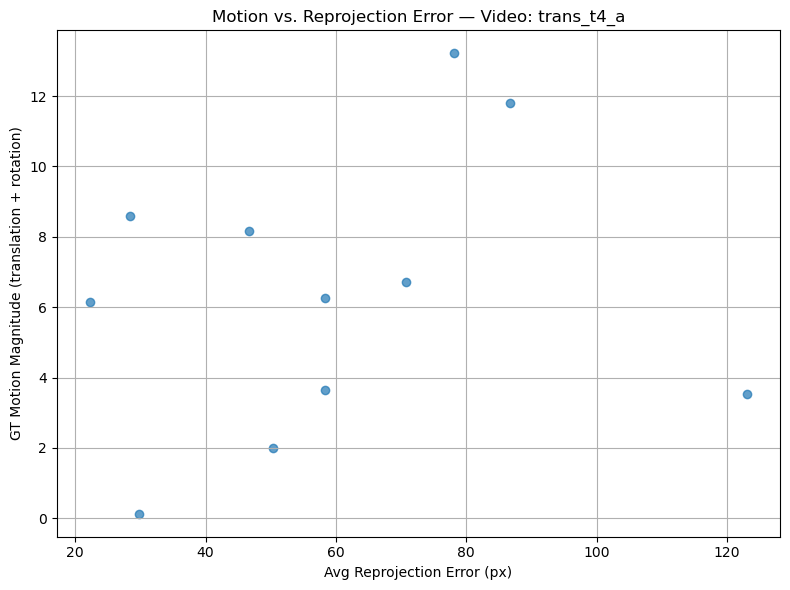

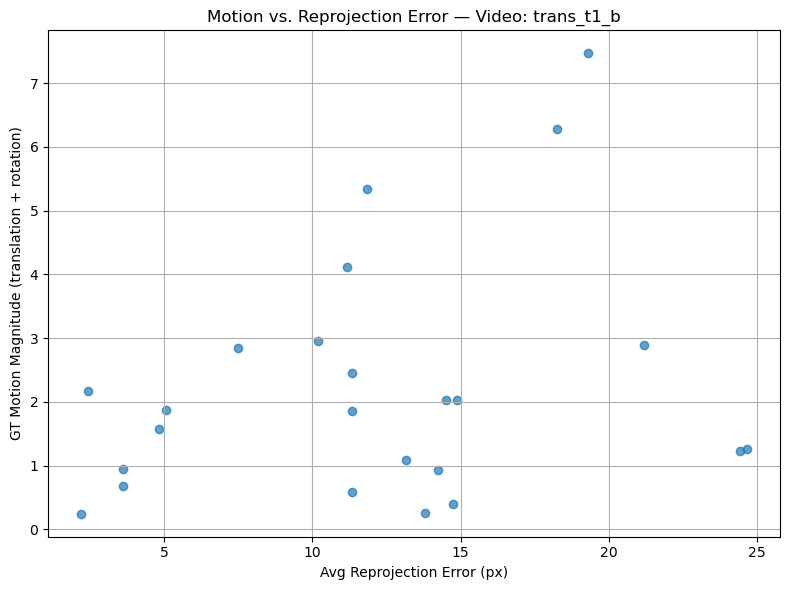

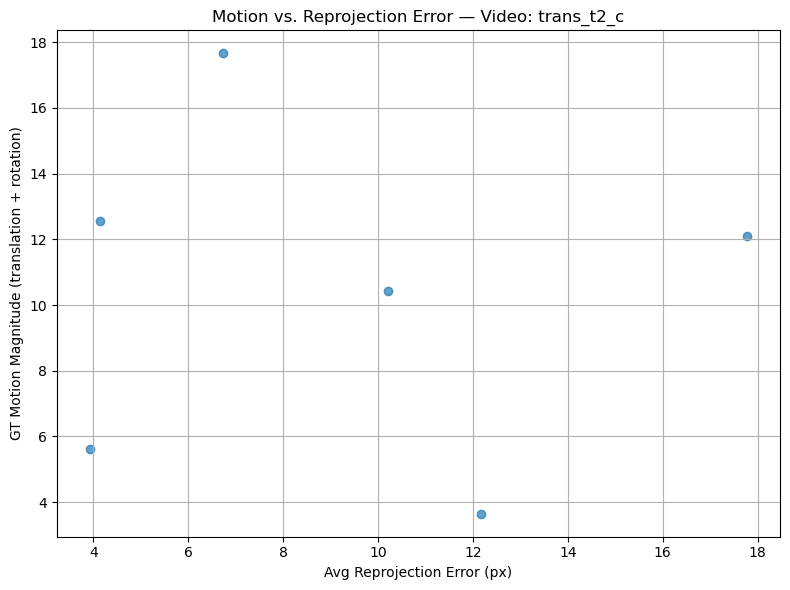

In [11]:
from scipy.spatial.transform import Rotation as R
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

for video in os.listdir(base_dir):
    video_path = os.path.join(base_dir, video)
    gt_pose_folder = os.path.join(video_path, "gt_poses")

    if not os.path.isdir(gt_pose_folder):
        continue

    # --- Step 1: Load GT motion ---
    motion_data = []
    for fname in sorted(os.listdir(gt_pose_folder)):
        if not fname.endswith(".npy"):
            # print(f"[WARN] Skipping non-npy file: {fname}")
            continue
        parts = fname.replace(".npy", "").split("_")
        if len(parts) < 4:
            # print(f"[WARN] Invalid filename format: {fname}")
            continue
        try:
            i1, i2 = int(parts[2]), int(parts[3])
        except:
            # print(f"[WARN] Failed to parse indices from: {fname}")
            continue

        T = np.load(os.path.join(gt_pose_folder, fname))
        trans = np.linalg.norm(T[:3, 3])
        rot_deg = R.from_matrix(T[:3, :3]).magnitude() * (180 / np.pi)

        motion_data.append({
            "frame": i2,
            "translation": trans,
            "rotation_deg": rot_deg,
            "combined_motion": trans + rot_deg
        })

    motion_df = pd.DataFrame(motion_data)
    if motion_df.empty:
        continue

    # --- Step 2: Collect Reproj from all matchers ---
    rpe_frames = []
    for matcher in os.listdir(video_path):
        matcher_path = os.path.join(video_path, matcher)

        # Skip the GT pose folder or any non-matcher folders
        if matcher == "gt_poses" or not os.path.isdir(matcher_path):
            continue

        metrics_path = os.path.join(matcher_path, "metrics_ensemble.csv")
        if not os.path.isfile(metrics_path):
            continue

        df = pd.read_csv(metrics_path)
        df = df.reset_index().rename(columns={"index": "frame"})
        if "frame" not in df.columns:
            continue

        rpe_frames.append(df)

    if not rpe_frames:
        continue

    # --- Step 3: Average RPE per frame ---
    rpe_all = pd.concat(rpe_frames)
    avg_rpe_df = rpe_all.groupby("frame").mean(numeric_only=True).reset_index()
    avg_rpe_df["frame"] = avg_rpe_df["frame"] * 30  # map to true frame numbers

    # --- Step 4: Merge and Plot ---
    plot_df = motion_df.merge(avg_rpe_df, on="frame")
    if plot_df.empty:
        continue

    plt.figure(figsize=(8, 6))
    plt.scatter(plot_df["mean_reprojection_error_px"], plot_df["combined_motion"], alpha=0.7)
    plt.xlabel("Avg Reprojection Error (px)")
    plt.ylabel("GT Motion Magnitude (translation + rotation)")
    plt.title(f"Motion vs. Reprojection Error — Video: {video}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(export_dir, f"motion_vs_rpe_scatter_{video}.png"), dpi=300)
    # plt.close()


### RPE Rot vs Trans per frame per matcher (one plot per video)

In [12]:

# # Loop over videos and plot RPE
# for video in os.listdir(base_dir):
#     if video in INVALID_GT_VIDEOS:
#         continue  # Skip invalid GT videos
#     video_df = metrics_df[metrics_df["video"] == video]
    
#     plt.figure(figsize=(10, 7))
#     plt.title(f"RPE Breakdown for Video: {video}")
#     plt.xlabel("Rotation Error (deg)")
#     plt.ylabel("Translation Error (deg)")
    
#     for _, row in video_df.iterrows():
#         matcher = row["matcher"]
#         x = row["rotation_error_deg"]
#         y = row["translation_error_deg"]

#         # Extract topfrac and thresh
#         match = re.search(r"topfrac(\d\.\d)_thresh(\d+)", matcher)
#         if match:
#             topfrac, thresh = match.groups()
#             label = f"[{topfrac},{thresh}]"
#             is_highlight = (topfrac, thresh) in highlight_set
#         else:
#             label = matcher
#             is_highlight = False

#         color = "red" if is_highlight else "blue"
#         plt.scatter(x, y, color=color)
#         plt.annotate(label, (x, y), fontsize=8, color=color)

#     # Add legend/key
#     plt.text(
#         0.95, 0.05,
#         "Key: [topfrac, thresh]\n"
#         "highlighted = Top 3 ATE configurations",
#         transform=plt.gca().transAxes,
#         fontsize=9,
#         verticalalignment='bottom',
#         horizontalalignment='right',
#         bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray")
#     )
    
#     plt.grid(True)
#     plt.tight_layout()
#     plt.savefig(os.path.join(export_dir, f'rpe_per_frame_{video}.png'), dpi=300)


### ATE vs RPE Rot Scatter PLot

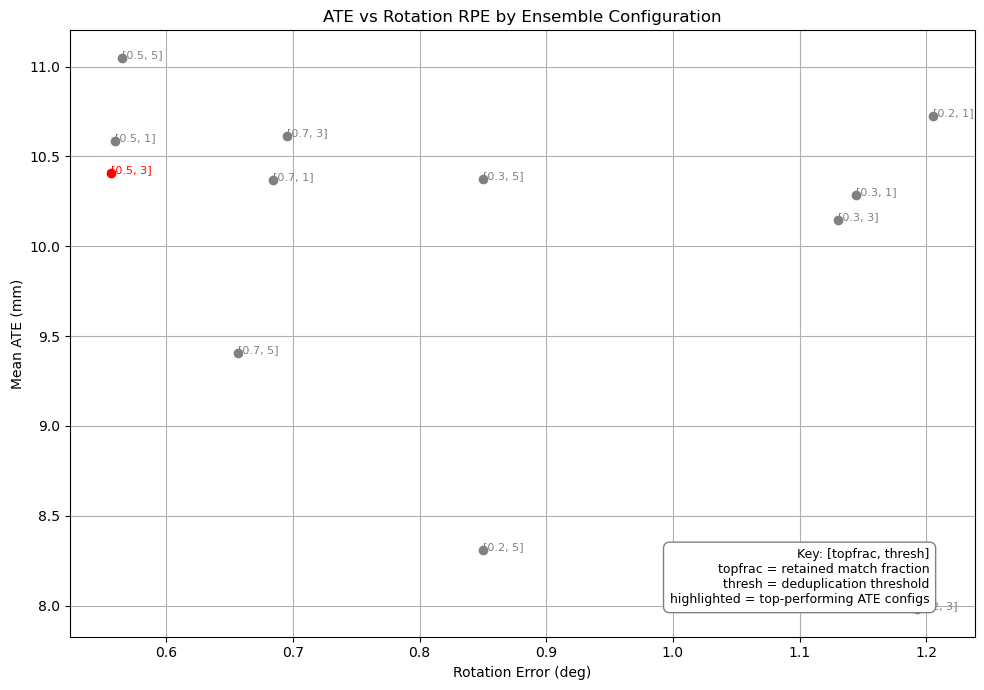

In [13]:

plt.figure(figsize=(10, 7))

for _, row in summary_df.iterrows():
    matcher = row["matcher"]
    rot_err = row["rotation_error_deg_mean"]
    ate = row["ATE_mean"]
    
    # Parse matcher name
    match = re.search(r"topfrac(\d\.\d)_thresh(\d+)", matcher)
    if match:
        topfrac, thresh = match.groups()
        label = f"[{topfrac}, {thresh}]"
        is_highlight = (topfrac, thresh) in highlight_set
    else:
        label = matcher
        is_highlight = False

    # Color coding
    color = "red" if is_highlight else "gray"
    
    plt.scatter(rot_err, ate, color=color)
    plt.annotate(label, (rot_err, ate), fontsize=8, color=color)

# Labels & Title
plt.xlabel("Rotation Error (deg)")
plt.ylabel("Mean ATE (mm)")
plt.title("ATE vs Rotation RPE by Ensemble Configuration")
plt.grid(True)
plt.tight_layout()

# Key box
plt.text(
    0.95, 0.05,
    "Key: [topfrac, thresh]\n"
    "topfrac = retained match fraction\n"
    "thresh = deduplication threshold\n"
    "highlighted = top-performing ATE configs",
    transform=plt.gca().transAxes,
    fontsize=9,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray")
)

plt.savefig(os.path.join(export_dir, 'ate_vs_rot_ensemble.png'), dpi=300)
# plt.close()

### Skip frames - one plot per video

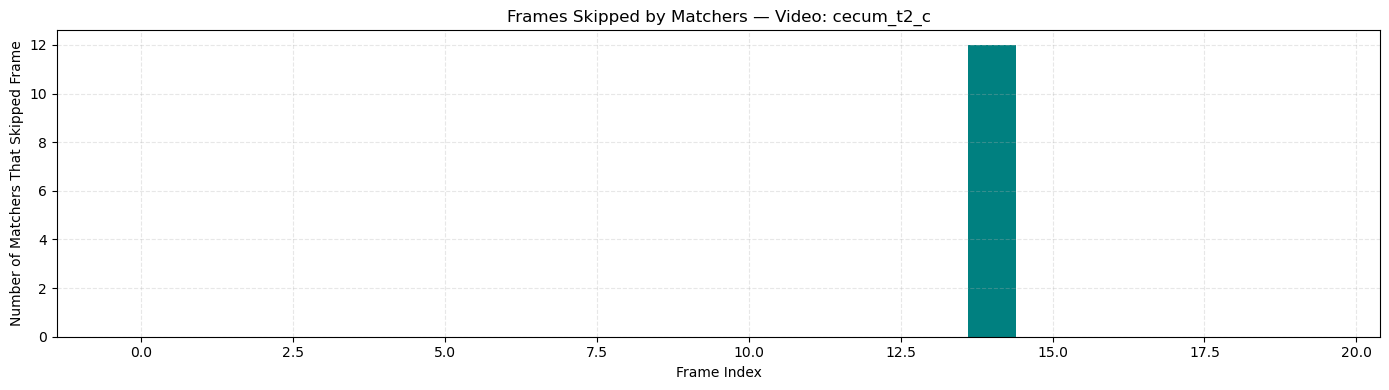

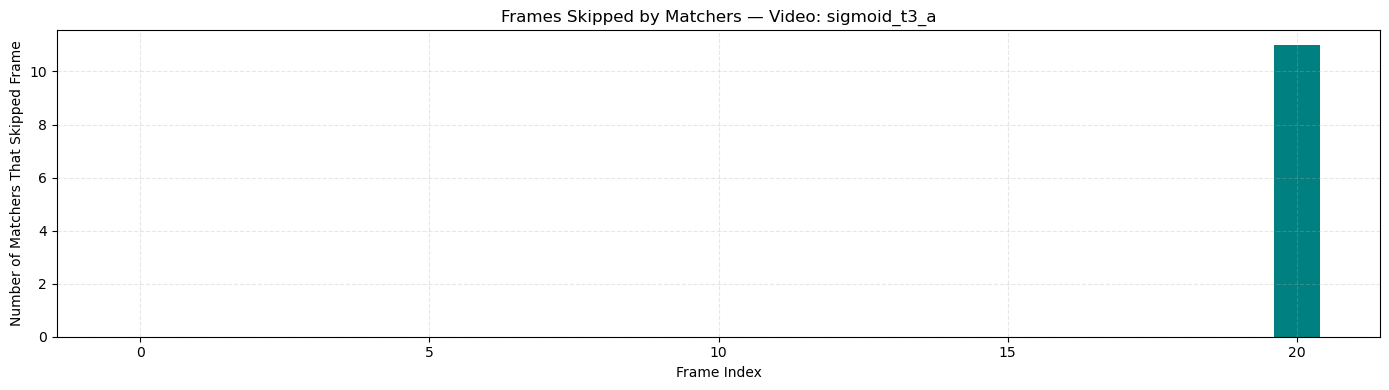

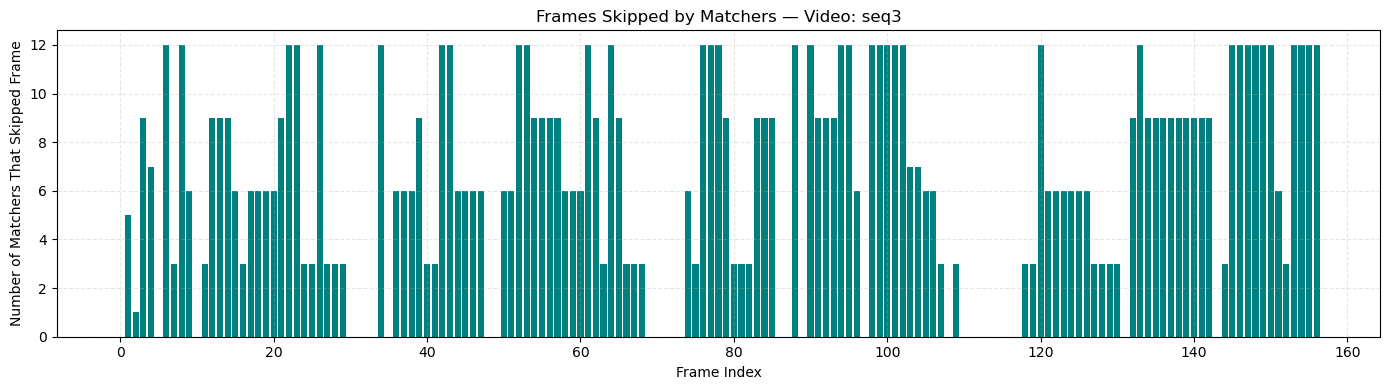

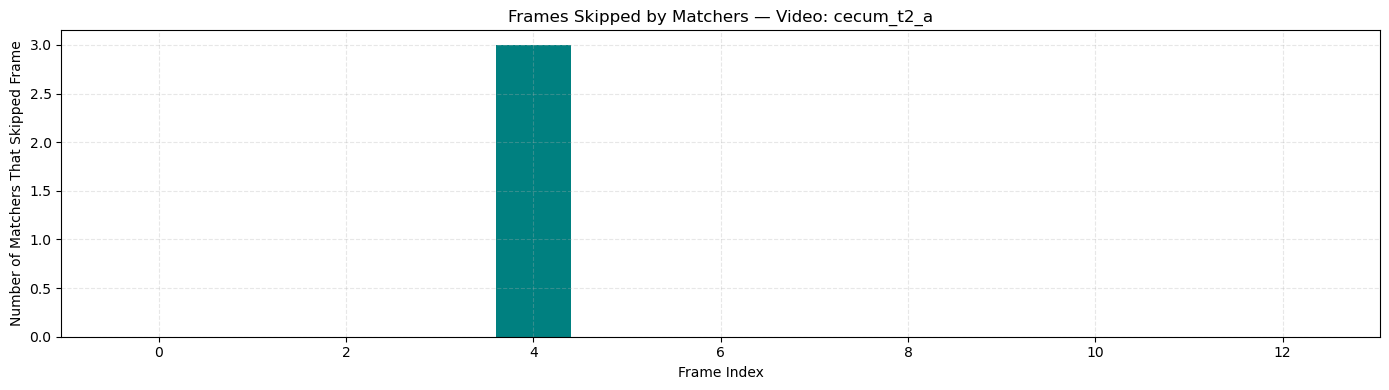

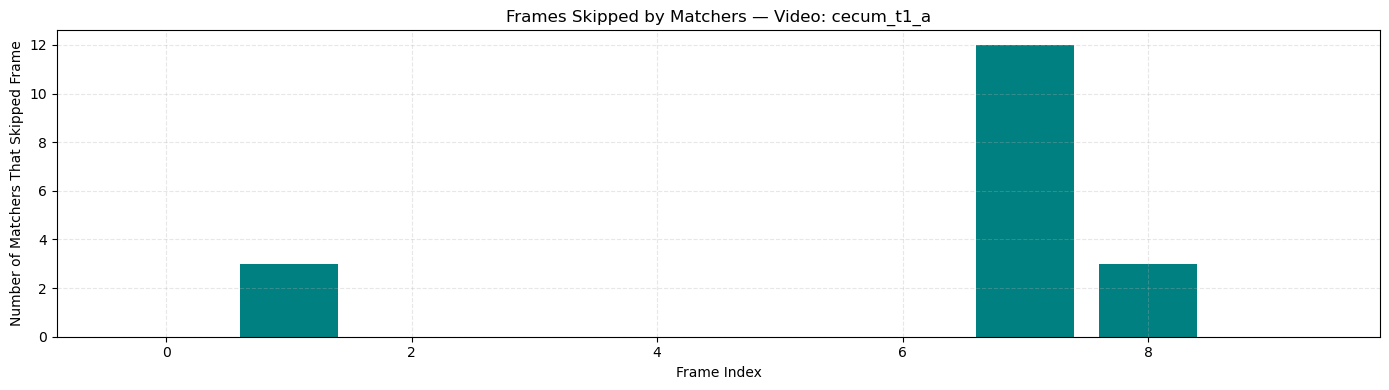

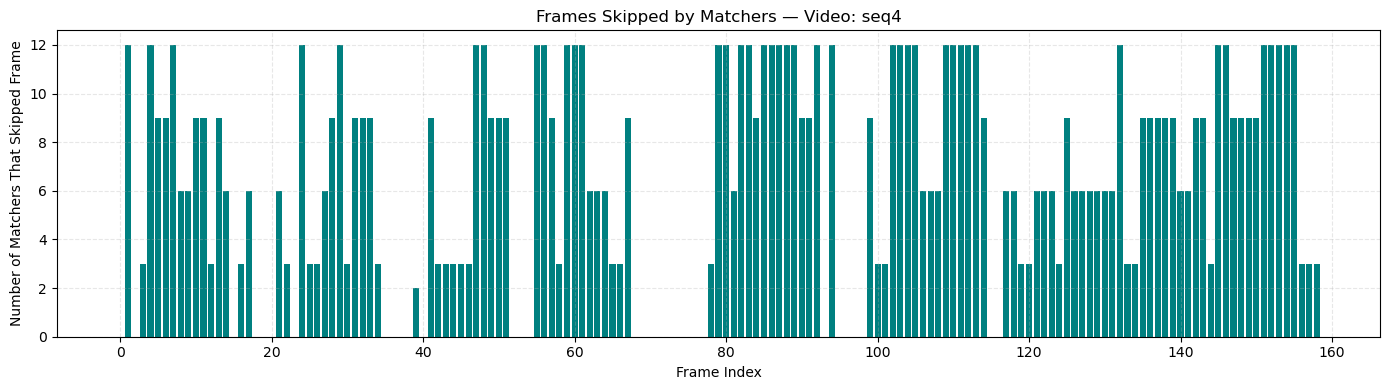

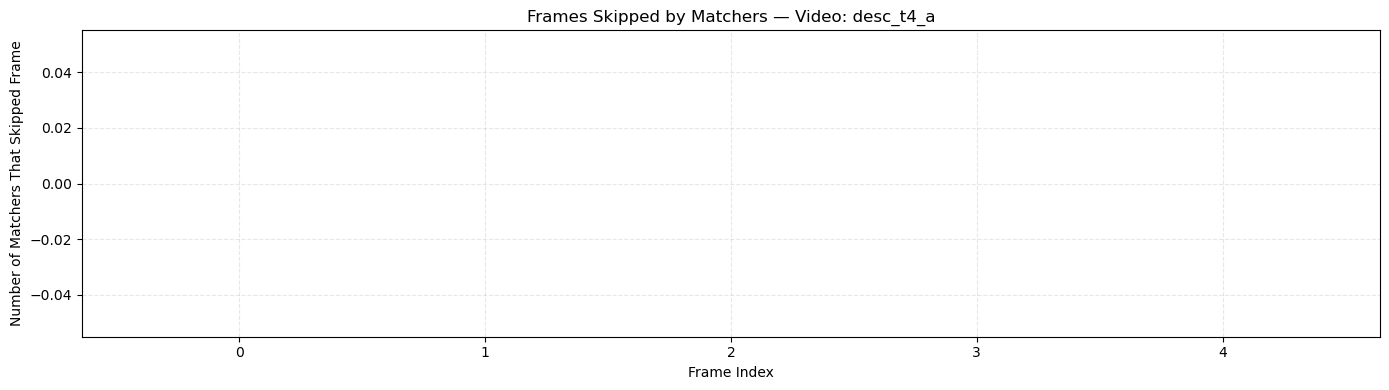

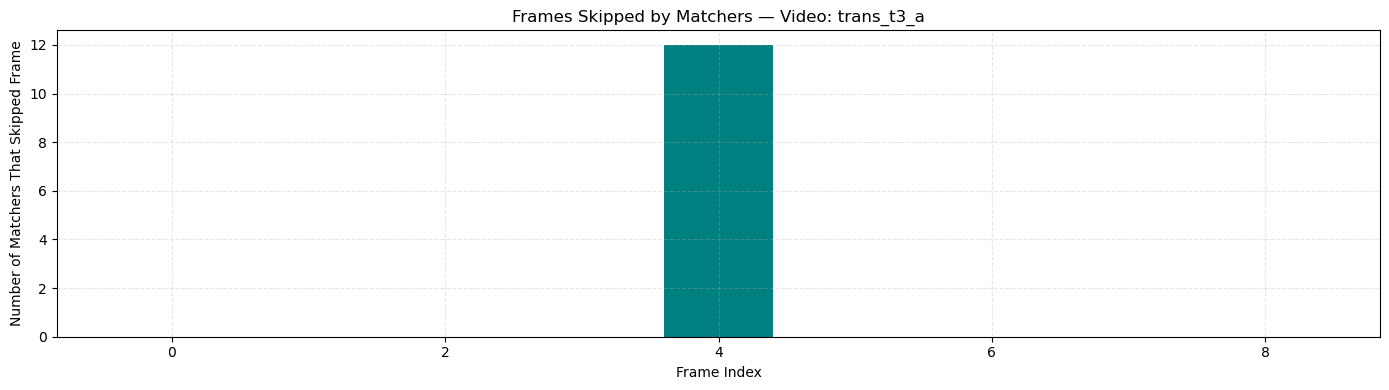

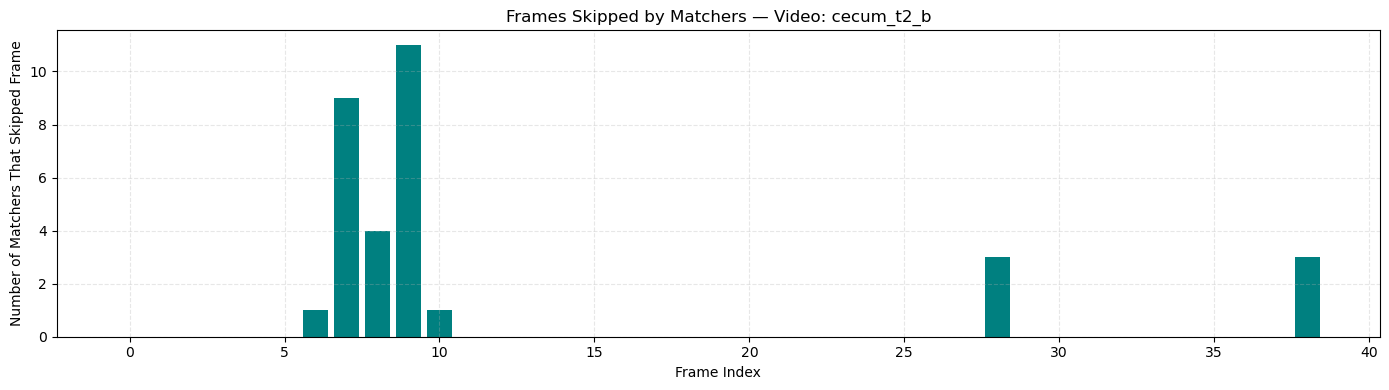

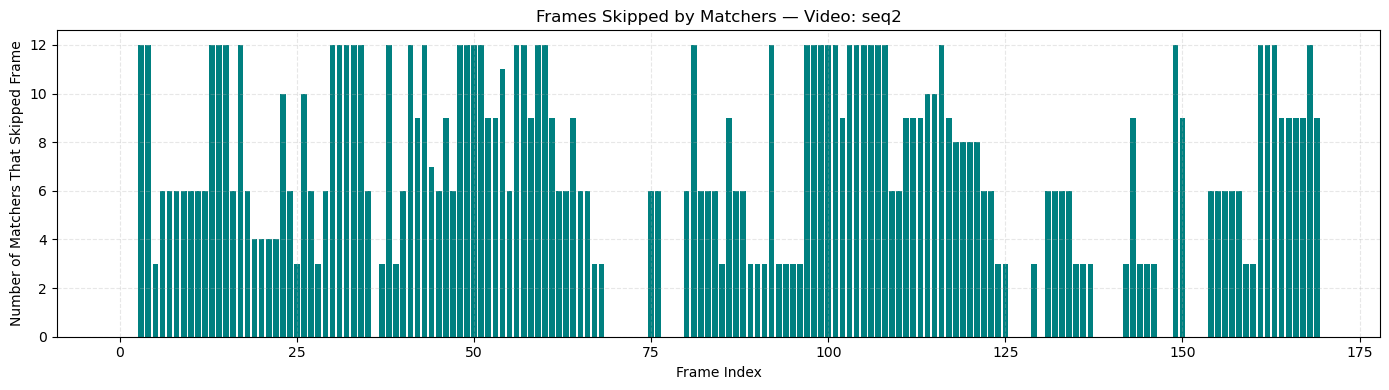

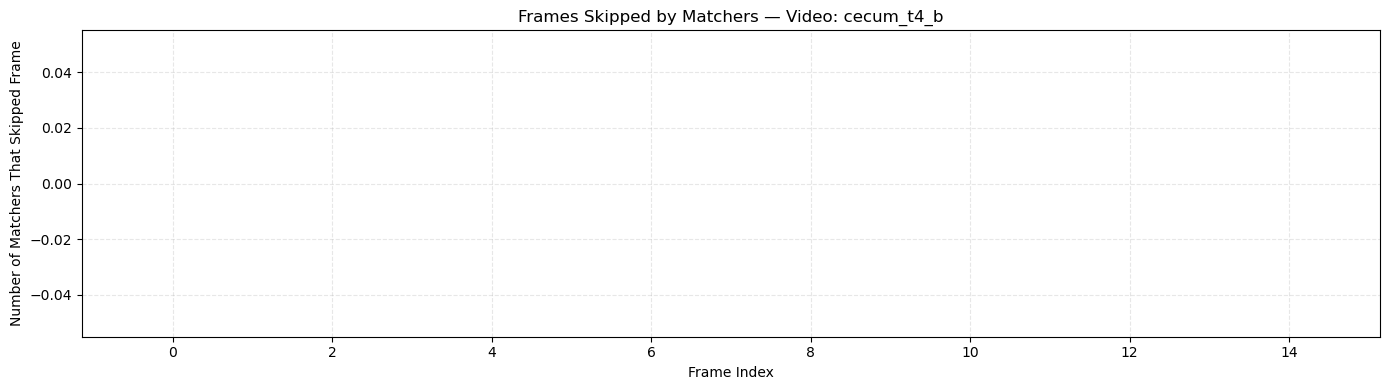

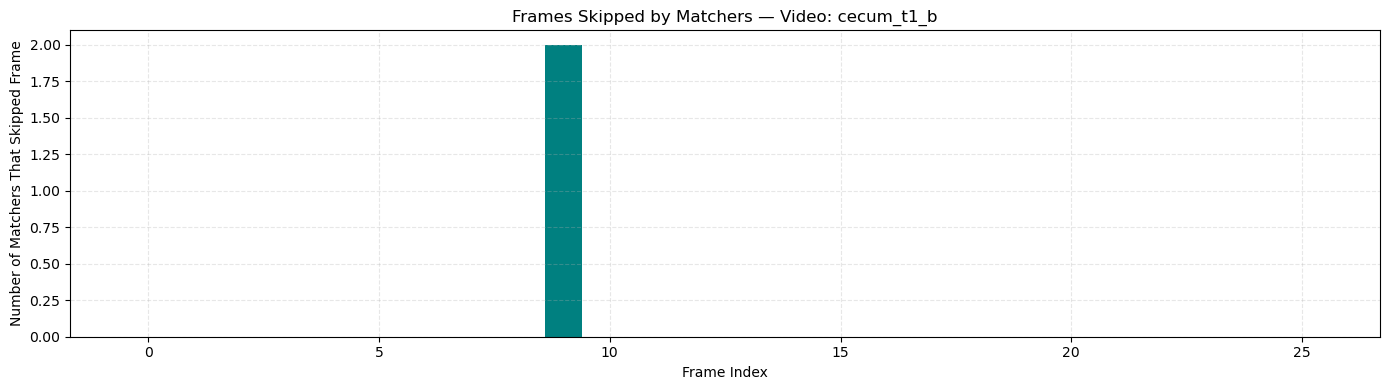

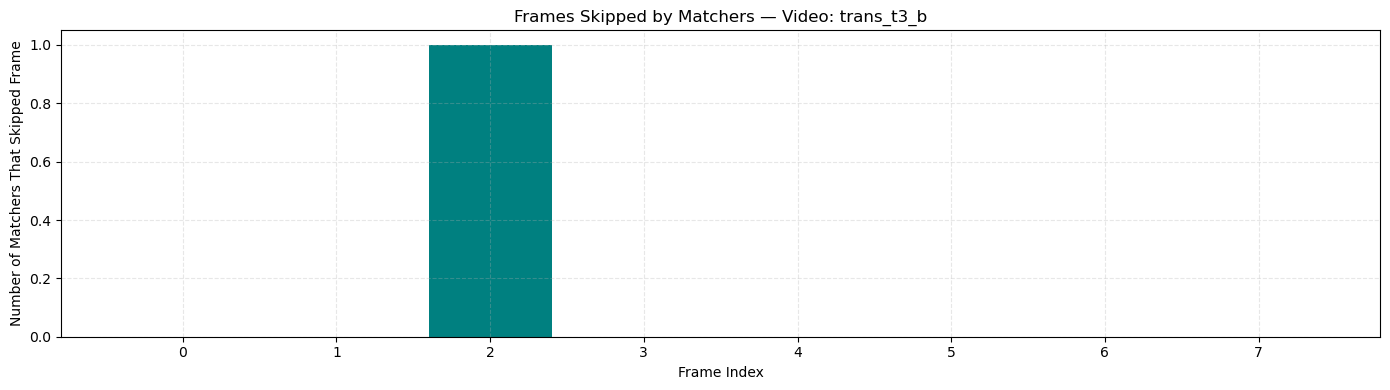

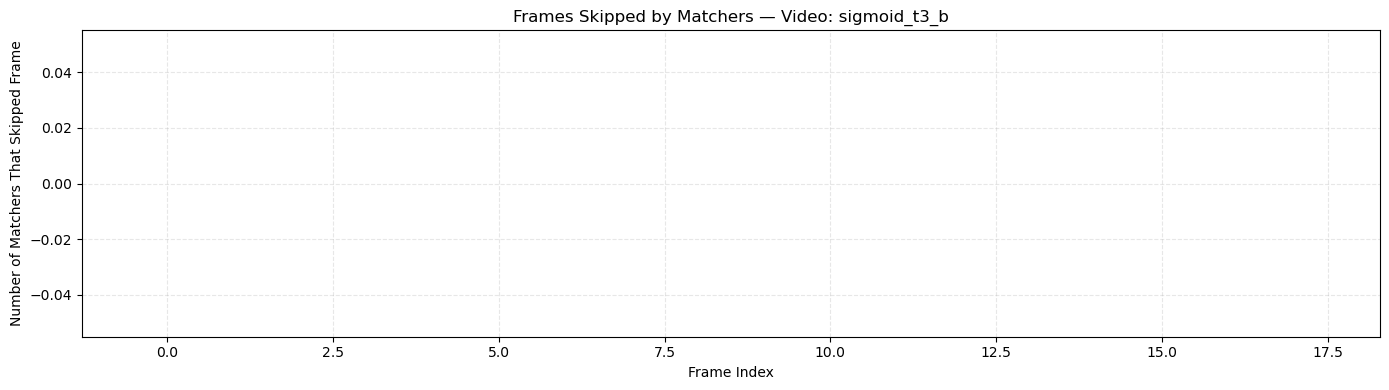

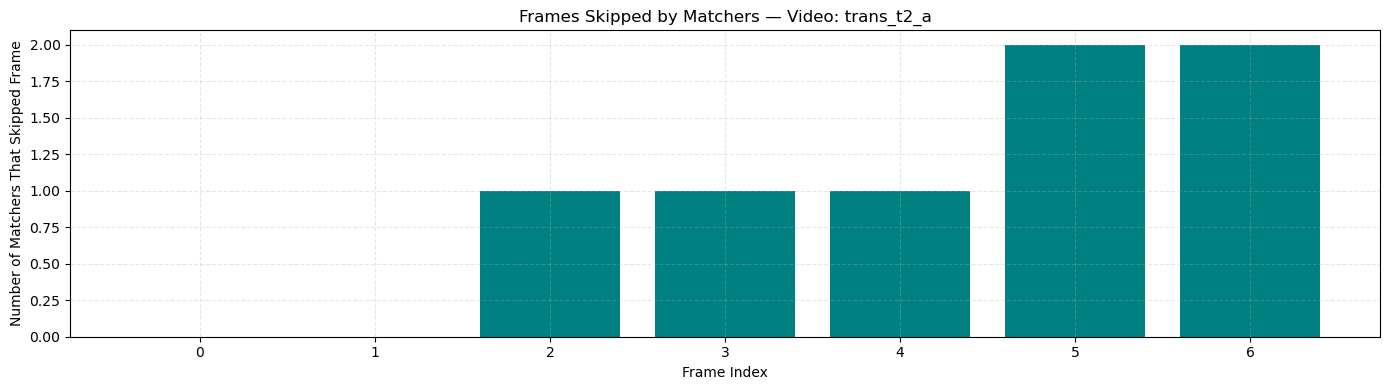

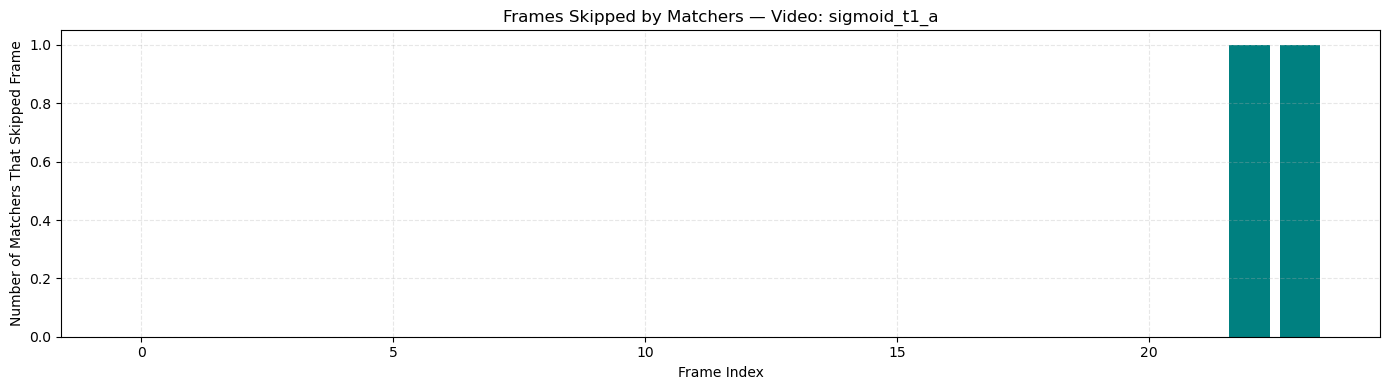

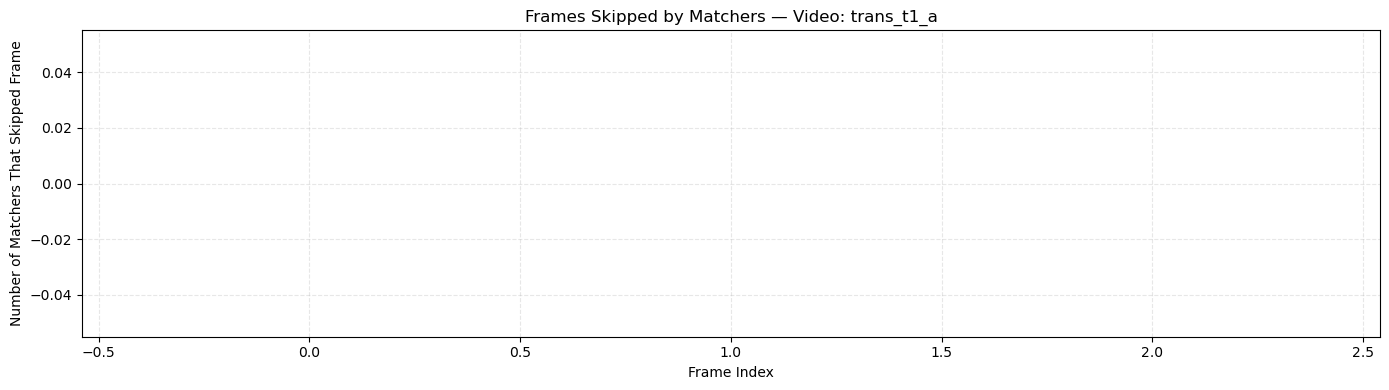

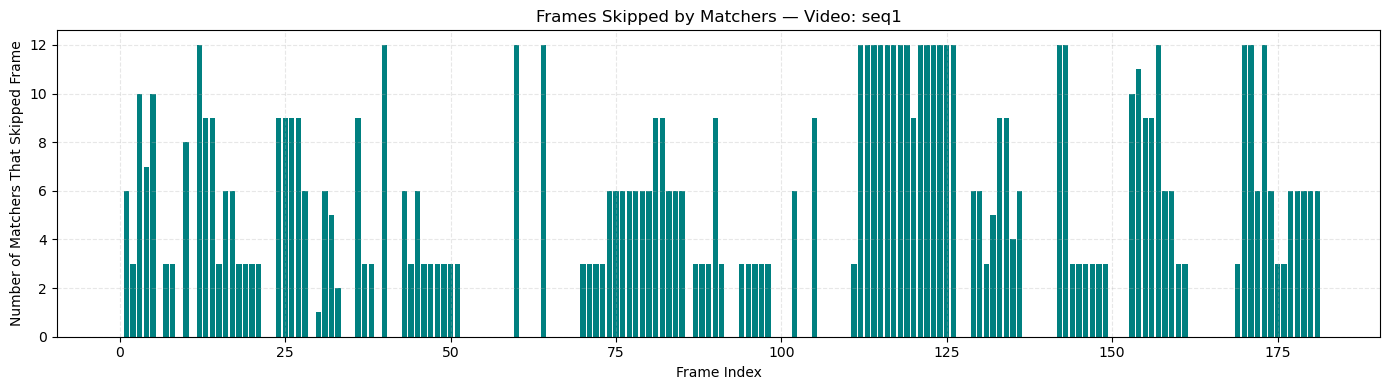

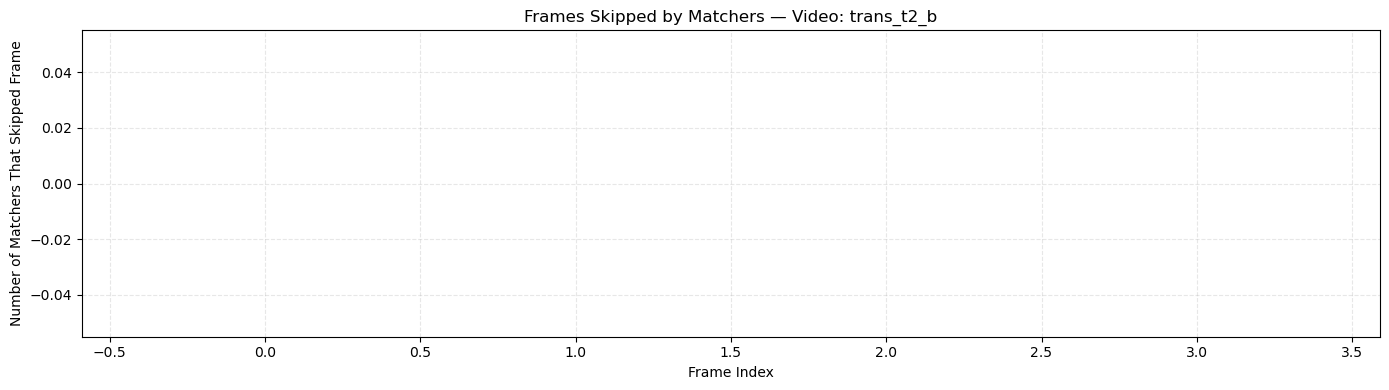

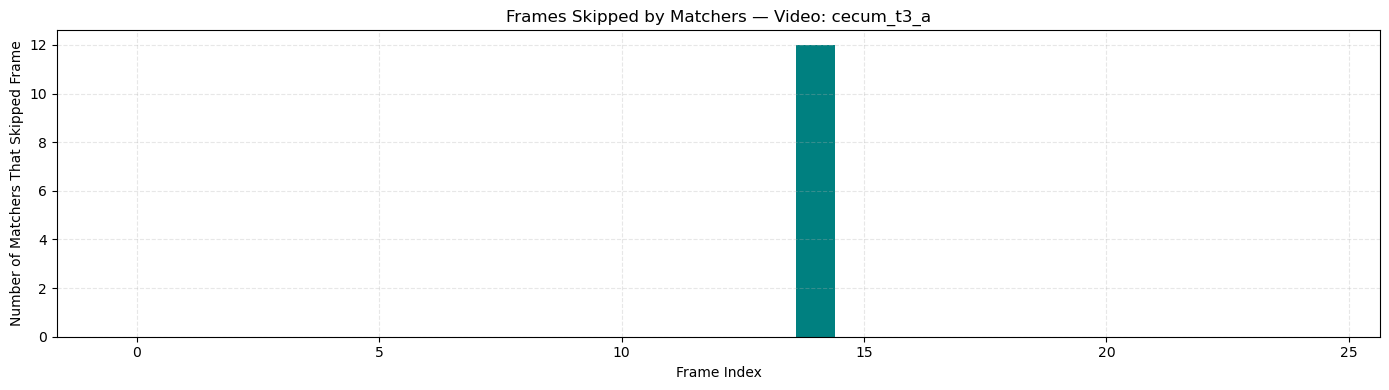

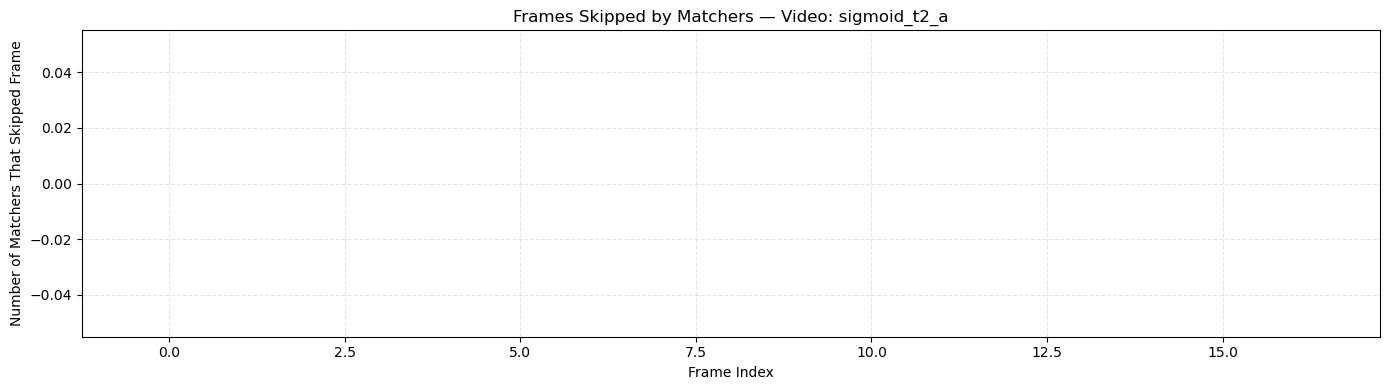

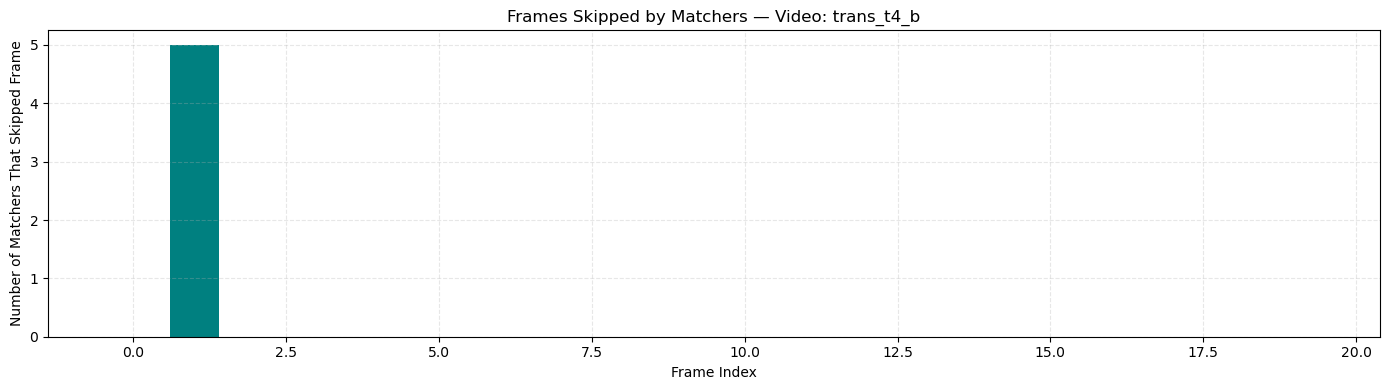

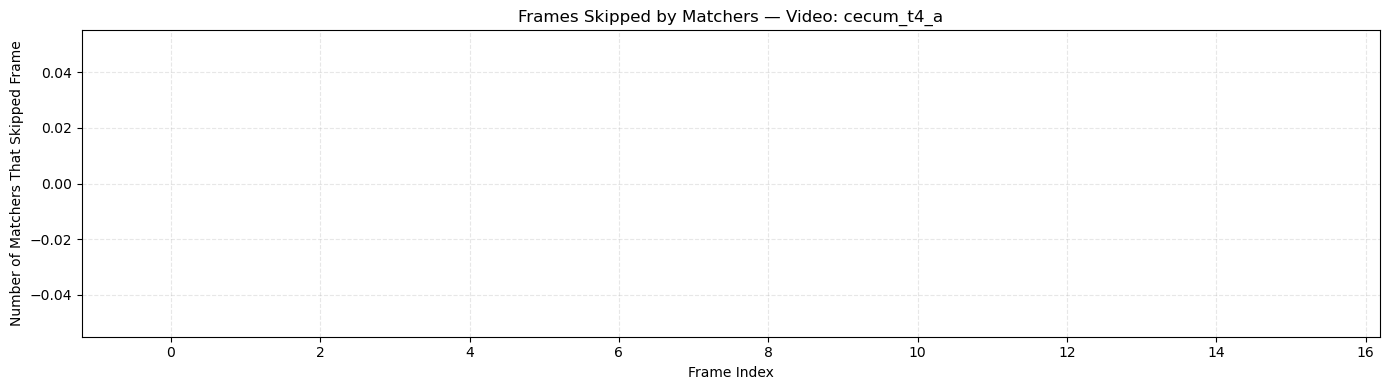

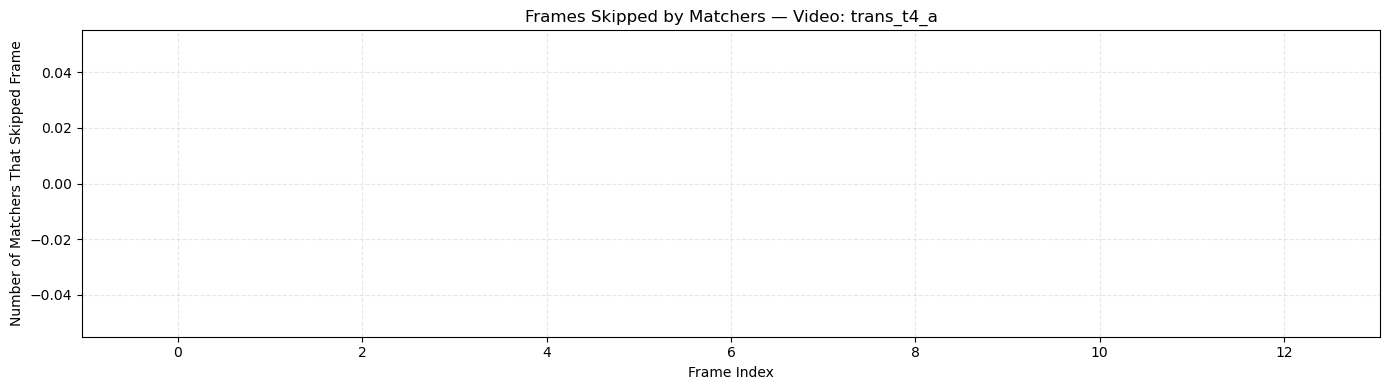

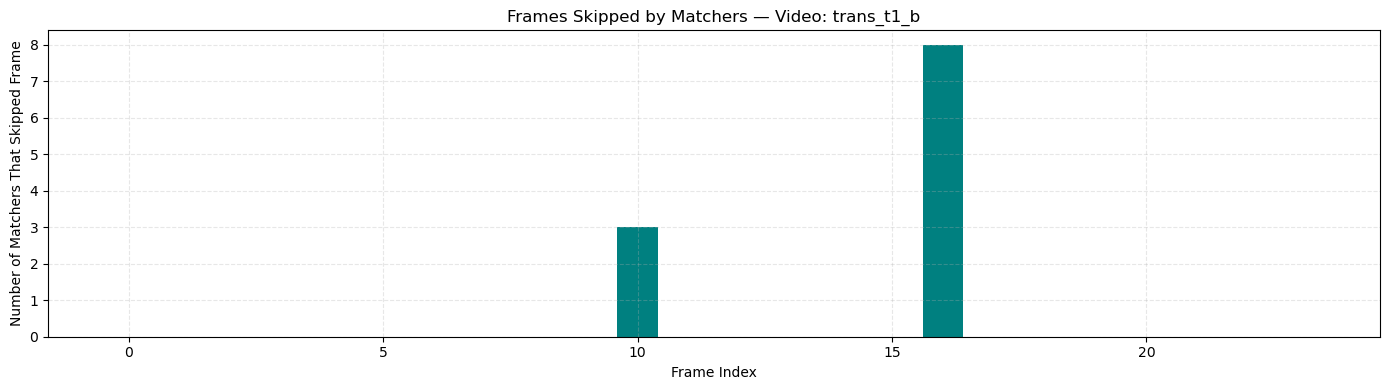

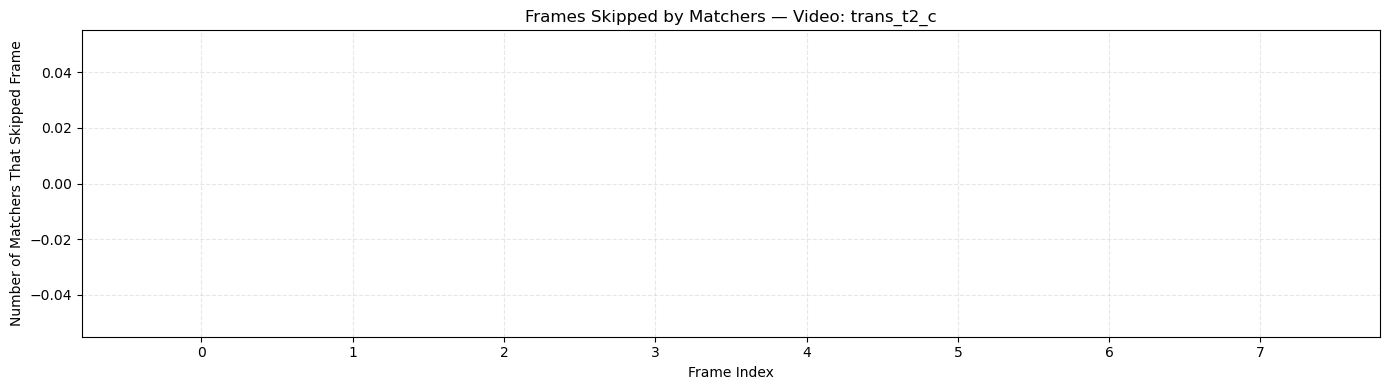

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

base_dir = "results/Ensemble_ablation"
export_dir = "ablation_outputs"
os.makedirs(export_dir, exist_ok=True)

allowed_matchers = {
    "ensemble_topfrac0.2_thresh1",
    "ensemble_topfrac0.2_thresh3",
    "ensemble_topfrac0.2_thresh5",
    "ensemble_topfrac0.3_thresh1",
    "ensemble_topfrac0.3_thresh3",
    "ensemble_topfrac0.3_thresh5",
    "ensemble_topfrac0.5_thresh1",
    "ensemble_topfrac0.5_thresh3",
    "ensemble_topfrac0.5_thresh5",
    "ensemble_topfrac0.7_thresh1",
    "ensemble_topfrac0.7_thresh3",
    "ensemble_topfrac0.7_thresh5",
}

for video in os.listdir(base_dir):
    video_path = os.path.join(base_dir, video)
    if not os.path.isdir(video_path):
        continue

    skip_counter = defaultdict(int)
    total_frames = 0

    for matcher in os.listdir(video_path):
        if matcher not in allowed_matchers:
            continue

        skip_log_path = os.path.join(video_path, matcher, "skip_log_ensemble.csv")
        if not os.path.isfile(skip_log_path):
            continue

        df = pd.read_csv(skip_log_path)
        total_frames = max(total_frames, int(df["frame_end"].dropna().astype(int).max()) + 1)

        # Track which frames were skipped by this matcher to avoid double-counting
        matcher_skips = set()

        for skipped_list in df["skipped_frames"]:
            if pd.isna(skipped_list) or skipped_list == "[]":
                continue
            skipped = [int(s) for s in skipped_list.strip("[]").split(",") if s.strip()]
            matcher_skips.update(skipped)

        # Add to global count (once per matcher per frame)
        for frame in matcher_skips:
            skip_counter[frame] += 1


    if total_frames == 0:
        continue

    # Build plot data
    full_range = list(range(total_frames))
    y_vals = [skip_counter.get(f, 0) for f in full_range]

    # Plot
    plt.figure(figsize=(14, 4))
    plt.bar(full_range, y_vals, color="teal")
    plt.title(f"Frames Skipped by Matchers — Video: {video}")
    plt.xlabel("Frame Index")
    plt.ylabel("Number of Matchers That Skipped Frame")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()

    # Save and show
    plot_path = os.path.join(export_dir, f"skips_{video}.png")
    plt.savefig(plot_path, dpi=300)
    plt.show()
    plt.close()


### ATE vs RPE Rot Sorted in symbol type

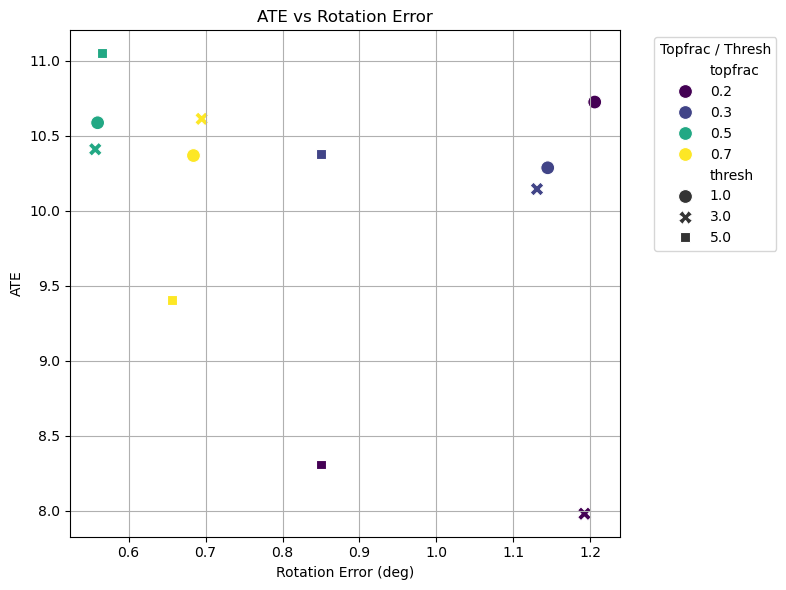

In [15]:
plt.figure(figsize=(8, 6))
summary_df['topfrac'] = summary_df['matcher'].str.extract(r'topfrac([0-9.]+)').astype(float)
summary_df['thresh'] = summary_df['matcher'].str.extract(r'thresh(\d+)').astype(float)

sns.scatterplot(
    data=summary_df,
    x="rotation_error_deg_mean",
    y="ATE_mean",
    hue="topfrac",     # Color by topfrac
    style="thresh",    # Marker style by thresh
    palette="viridis",
    s=100
)

plt.title("ATE vs Rotation Error")
plt.xlabel("Rotation Error (deg)")
plt.ylabel("ATE")
plt.legend(title="Topfrac / Thresh", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


### Analysis without trans_t4_b

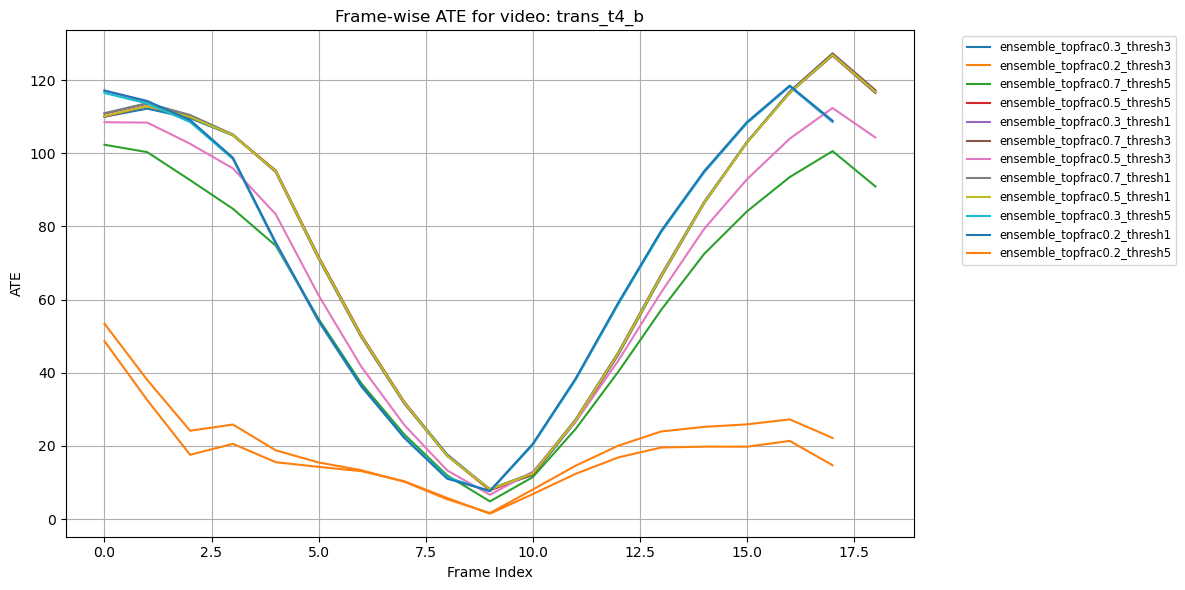

In [16]:
video = "trans_t4_b"  # ← pick the video you want
video_path = f"results/Ensemble_ablation/{video}"

ensemble_ates = {}

# Loop through all ensemble configs for this video
for matcher in os.listdir(video_path):
    ate_path = os.path.join(video_path, matcher, "ate_ensemble.npy")
    if os.path.isfile(ate_path):
        try:
            ate = np.load(ate_path).flatten()
            ensemble_ates[matcher] = ate
        except Exception as e:
            print(f"Failed to load {matcher}: {e}")

# Plot all ensemble ATE series
plt.figure(figsize=(12, 6))

for matcher, ate_values in ensemble_ates.items():
    plt.plot(ate_values, label=matcher)

plt.xlabel("Frame Index")
plt.ylabel("ATE")
plt.title(f"Frame-wise ATE for video: {video}")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()


           video   mean_ate       std_ate
21    trans_t2_c   0.780898  1.996636e-01
5     trans_t3_a   1.089404  2.933915e-01
20    trans_t1_b   1.801906  7.039071e-01
16  sigmoid_t2_a   2.040126  1.112160e+00
13    trans_t1_a   2.329995  3.140185e-16
10  sigmoid_t3_b   3.151778  1.488305e+00
7     cecum_t4_b   3.304693  1.907882e+00
3     cecum_t1_a   3.519766  1.092660e+00
15    cecum_t3_a   3.962241  2.304325e+00
2     cecum_t2_a   4.966546  3.851275e+00
0     cecum_t2_c   5.114278  1.534971e+00
4      desc_t4_a   7.494004  3.178105e+00
19    trans_t4_a   8.019798  3.461488e+00
11    trans_t2_a   9.727096  7.737756e+00
8     cecum_t1_b   9.959871  4.378902e+00
12  sigmoid_t1_a  10.100771  5.543279e+00
1   sigmoid_t3_a  10.233322  4.548906e+00
9     trans_t3_b  16.675167  7.304829e+00
14    trans_t2_b  18.644249  1.087844e+01
6     cecum_t2_b  18.666676  7.795296e+00
18    cecum_t4_a  19.816653  8.459312e+00
17    trans_t4_b  67.605295  3.661588e+01


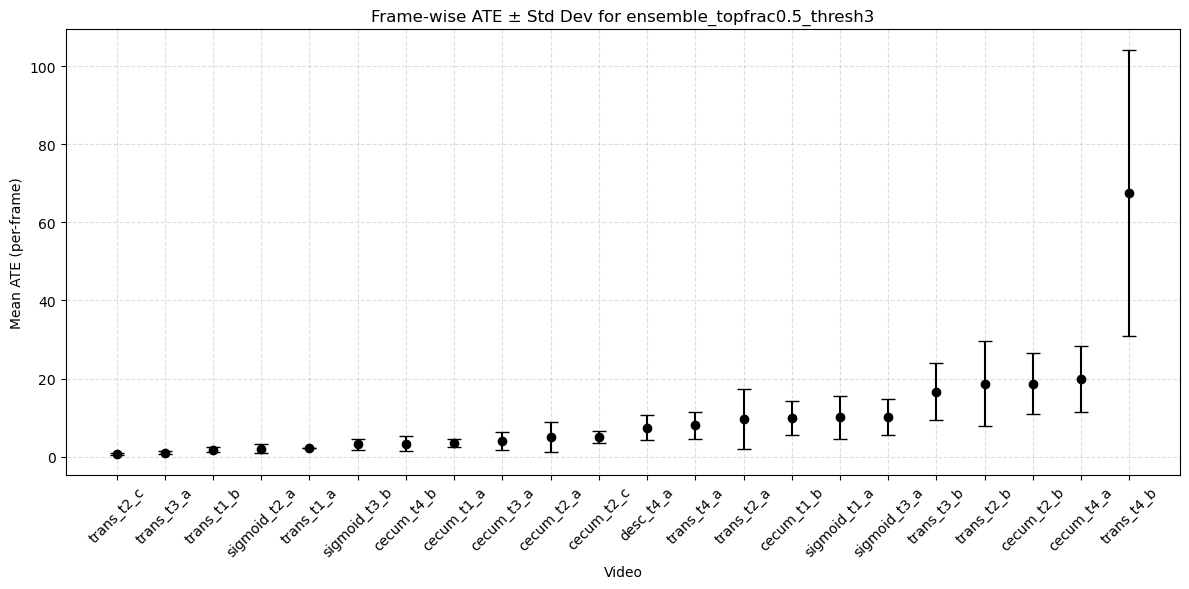

In [17]:
# import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Choose the matcher to analyze
target_matcher = "ensemble_topfrac0.5_thresh3"
base_dir = "results/Ensemble_ablation"

records = []

for video in os.listdir(base_dir):
    if video in INVALID_GT_VIDEOS:
        continue
    matcher_path = os.path.join(base_dir, video, target_matcher)
    ate_path = os.path.join(matcher_path, "ate_ensemble.npy")

    if os.path.isfile(ate_path):
        try:
            ate = np.load(ate_path).astype(float).flatten()
            records.append({
                "video": video,
                "mean_ate": np.mean(ate),
                "std_ate": np.std(ate)
            })
        except Exception as e:
            print(f"Error loading {ate_path}: {e}")

# Build DataFrame
df = pd.DataFrame(records).sort_values("mean_ate")
print(df)

plt.figure(figsize=(12, 6))
for i, row in df.iterrows():
    plt.errorbar(
        x=row["video"],
        y=row["mean_ate"],
        yerr=row["std_ate"],
        fmt='o',
        capsize=5,
        color='black'
    )

plt.xticks(rotation=45)
plt.ylabel("Mean ATE (per-frame)")
plt.xlabel("Video")
plt.title(f"Frame-wise ATE ± Std Dev for {target_matcher}")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

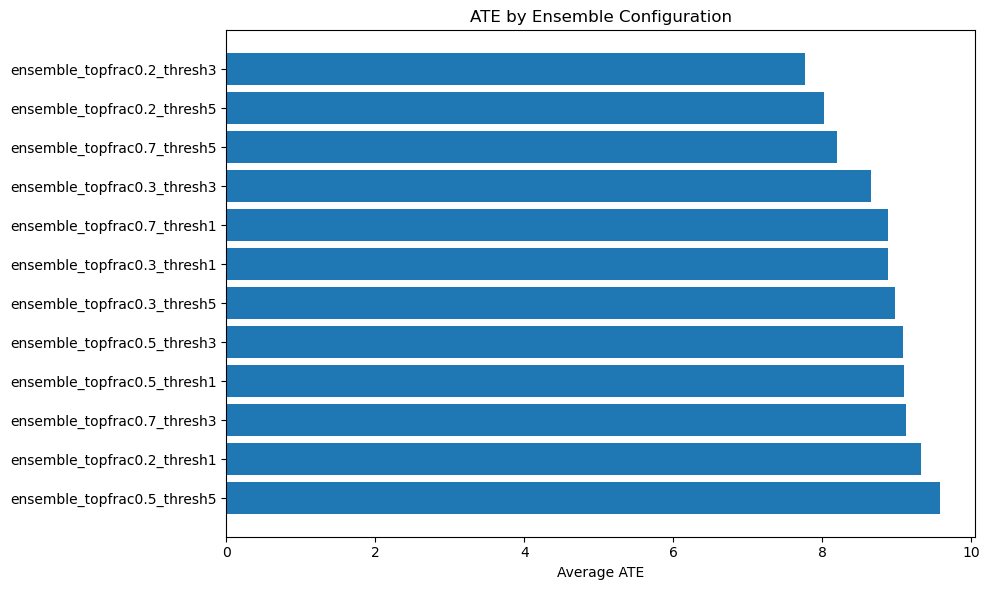

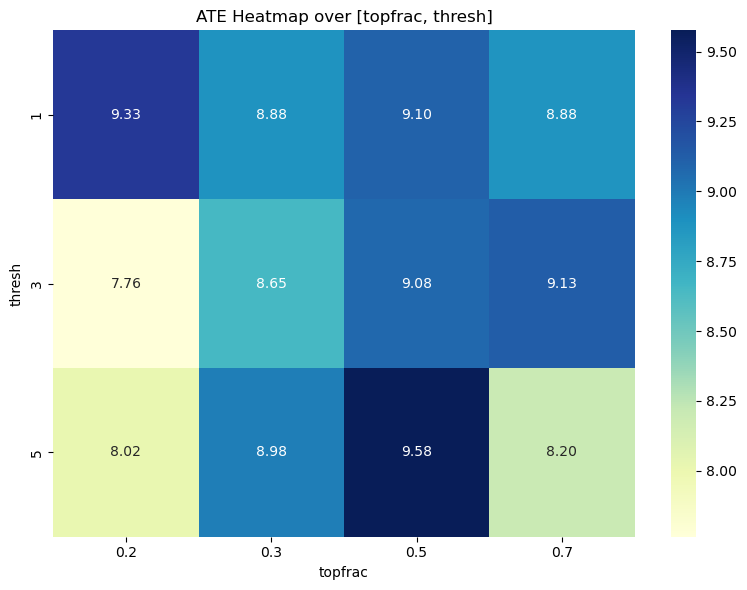

In [18]:
INVALID_GT_VIDEOS = {"seq1", "seq2", "seq3", "seq4", "trans_t4_b"}
# Load data from all videos and matchers
for video in os.listdir(base_dir):
    if video in INVALID_GT_VIDEOS:
        continue  # Skip invalid GT videos
    # print(f"Processing video: {video}")
    video_path = os.path.join(base_dir, video)
    if not os.path.isdir(video_path):
        continue

    for matcher in os.listdir(video_path):
        matcher_path = os.path.join(video_path, matcher)
        metrics_file = os.path.join(matcher_path, "metrics_ensemble.csv")
        ate_file = os.path.join(matcher_path, "ate_ensemble.npy")
        skip_log_file = os.path.join(matcher_path, "skip_log_ensemble.csv")

        # Parse topfrac/thresh from matcher name
        match = re.search(r"topfrac(\d\.\d)_thresh(\d+)", matcher)
        if not match:
            continue  # skip if pattern not found
        topfrac, thresh = match.groups()
        if topfrac not in VALID_TOPFRACS or thresh not in VALID_THRESHOLDS:
            continue  # skip non-included runs

        # Load metrics
        if os.path.isfile(metrics_file):
            df = pd.read_csv(metrics_file)
            df["matcher"] = matcher
            df["video"] = video
            all_metrics.append(df)

        # Load ATE
        if os.path.isfile(ate_file):
            ate_value = load_ate_scalar(ate_file)
            if ate_value is not None and ate_value > 0:
                ate_dict.setdefault(matcher, []).append(ate_value)
            else:
                print(f"[SKIP] Invalid or 0 ATE for {matcher} ({video})")

        # Load skip log
        if os.path.isfile(skip_log_file):
            try:
                skip_df = pd.read_csv(skip_log_file)
                total = len(skip_df)
                failed = skip_df["success"].value_counts().get(False, 0)
                avg_skip_used = skip_df["skip_used"].mean()

                skip_stats.append({
                    "matcher": matcher,
                    "video": video,
                    "failures": failed,
                    "total": total,
                    "failure_rate": failed / total if total > 0 else np.nan,
                    "avg_skip_used": avg_skip_used
                })

            except Exception as e:
                print(f"[WARN] Failed to load skip log from {skip_log_file}: {e}")

# --- Combine & Aggregate ---
metrics_df = pd.concat(all_metrics, ignore_index=True)

# Group by matcher and compute mean and std metrics
agg_funcs = {
    "rotation_error_deg": ["mean", "std"],
    "translation_error_deg": ["mean", "std"],
    "mean_reprojection_error_px": ["mean", "std"]
}
summary_df = metrics_df.groupby("matcher").agg(agg_funcs)
summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]
summary_df = summary_df.reset_index()

# Add ATE means and stds
ate_avg = {matcher: np.mean(values) for matcher, values in ate_dict.items()}
ate_std = {matcher: np.std(values) for matcher, values in ate_dict.items()}
summary_df["ATE_mean"] = summary_df["matcher"].map(ate_avg)
summary_df["ATE_std"] = summary_df["matcher"].map(ate_std)

# Add skip log stats
skip_df = pd.DataFrame(skip_stats)
skip_summary = skip_df.groupby("matcher").agg({
    "failure_rate": "mean",
    "avg_skip_used": "mean"
}).reset_index()

summary_df = summary_df.merge(skip_summary, on="matcher", how="left")

# # OPTIONAL: sort or inspect
# summary_df = summary_df.sort_values("ATE_mean")


# Sort by ATE ascending, then reverse so smallest is on top
sorted_df = summary_df.sort_values("ATE_mean", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(sorted_df["matcher"], sorted_df["ATE_mean"])
plt.xlabel("Average ATE")
plt.title("ATE by Ensemble Configuration")
plt.gca().invert_yaxis()  # <-- This inverts the y-axis so smallest ATE is at the top
plt.tight_layout()
plt.savefig(os.path.join(export_dir, 'ate_bar_plot.png'), dpi=300)
# plt.close()


summary_df["topfrac"] = summary_df["matcher"].str.extract(r"topfrac(\d\.\d)")[0].astype(float)
summary_df["thresh"] = summary_df["matcher"].str.extract(r"thresh(\d+)")[0].astype(int)

heatmap_data = summary_df.pivot(index="thresh", columns="topfrac", values="ATE_mean")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")

plt.title("ATE Heatmap over [topfrac, thresh]")
plt.xlabel("topfrac")
plt.ylabel("thresh")
plt.tight_layout()
plt.savefig(os.path.join(export_dir, 'ATE_heatmap_ensemble.png'), dpi=300)
plt.show
# plt.close()
